In [1]:
# CELL 1: Install Dependencies and Import Libraries
!pip install imbalanced-learn xgboost shap streamlit plotly -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           roc_curve, accuracy_score, precision_score, recall_score, f1_score)
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import shap
import joblib
import warnings
warnings.filterwarnings("ignore")

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print("📱 Ready for Project success prediction project!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 32.0 MB/s eta 0:00:00
✅ All libraries imported successfully!
📱 Ready for Project success prediction project!


In [2]:
# CELL 2: Data Loading and Initial Analysis
print("🔍 LOADING DATASET")
print("="*50)

# Upload your CSV file to Colab first
# You can use: from google.colab import files; uploaded = files.upload()
# Or mount Google Drive: from google.colab import drive; drive.mount('/content/drive')

# Load your dataset - adjust the path as needed
try:
    df = pd.read_csv("/content/ProjectDatas.csv")  # Change this to your actual file path
    print("✅ Dataset loaded successfully!")
except FileNotFoundError:
    # Create a sample dataset for demonstration
    print("⚠️ DATA.csv not found. Creating sample dataset...")
    np.random.seed(42)

    n_samples = 1000
    df = pd.DataFrame({
        'Industry_of_Project': np.random.randint(1, 11, n_samples),
        'Employee_Count': np.random.randint(5, 200, n_samples),
        'team_size_grown': np.random.randint(0, 5, n_samples),
        'Number_of_Co_founders': np.random.randint(1, 5, n_samples),
        'Team_size_Senior_leadership': np.random.randint(2, 10, n_samples),
        'customer_satisfaction_score': np.random.uniform(3, 10, n_samples),
        'scalability_score': np.random.uniform(30, 100, n_samples),
        'churn_rate': np.random.uniform(0.01, 0.4, n_samples),
        'burn_rate': np.random.uniform(2, 20, n_samples),
        'customer_acquisition_cost': np.random.uniform(20, 200, n_samples),
        'monthly_recurring_revenue': np.random.uniform(5000, 100000, n_samples),
        'business_sustainability_score': np.random.uniform(40, 100, n_samples),
        'User_Adoption_Rate': np.random.uniform(0.1, 0.9, n_samples),
        'Revenue_Growth': np.random.uniform(-5, 30, n_samples),
        'Market_Competition': np.random.randint(1, 6, n_samples),
    })

    # Create target based on logical rules
    success_score = (
        (df['customer_satisfaction_score'] > 7) * 20 +
        (df['churn_rate'] < 0.1) * 15 +
        (df['scalability_score'] > 70) * 15 +
        (df['Employee_Count'] > 30) * 10 +
        (df['team_size_grown'] > 0) * 10 +
        (df['burn_rate'] < 10) * 10 +
        (df['Revenue_Growth'] > 10) * 10 +
        np.random.normal(0, 10, n_samples)  # Add some noise
    )

    df['Dependent_Project_Status'] = (success_score > 45).astype(int)

    print("📊 Sample dataset created with logical success patterns")

print(f"\n📊 Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Display basic info
print("\n📈 Data Types:")
print(df.dtypes.value_counts())

print("\n❓ Missing Values:")
missing_summary = df.isnull().sum()
if missing_summary.sum() > 0:
    print(missing_summary[missing_summary > 0])
else:
    print("No missing values found!")

print("\n🔍 First 5 rows:")
df.head()

🔍 LOADING DATASET
✅ Dataset loaded successfully!

📊 Dataset Overview:
Shape: (3240, 21)
Columns: ['Industry_of_Project', 'Employee_Count', 'team_size_grown', 'Number_of_Co_founders', 'customer_satisfaction_score', 'churn_rate', 'scalability_score', 'monthly_recurring_revenue', 'burn_rate', 'business_sustainability_score', 'User_Adoption_Rate', 'Revenue_Growth', 'Market_Competition', 'customer_acquisition_cost', 'Dependent_Project_Status', 'revenue_to_burn_ratio', 'revenue_per_employee', 'satisfaction_adoption_product', 'churn_competition_risk', 'growth_sustainability_score', 'team_growth_efficiency']

📈 Data Types:
int64      10
float64    10
object      1
Name: count, dtype: int64

❓ Missing Values:
No missing values found!

🔍 First 5 rows:


,Industry_of_Project,Employee_Count,team_size_grown,Number_of_Co_founders,customer_satisfaction_score,churn_rate,scalability_score,monthly_recurring_revenue,burn_rate,business_sustainability_score,...,Revenue_Growth,Market_Competition,customer_acquisition_cost,Dependent_Project_Status,revenue_to_burn_ratio,revenue_per_employee,satisfaction_adoption_product,churn_competition_risk,growth_sustainability_score,team_growth_efficiency
0,Security,112,3,2,7.20,0.010,75,67208,33017,97,...,10.43,3,76,1,2.035496,594.761062,6.08400,0.030,19.8171,1.784283
1,Retail,41,1,3,7.39,0.010,97,73104,18911,65,...,15.10,1,181,1,3.865482,1740.571429,6.85792,0.010,16.3150,1.740571
2,Healthcare,25,1,1,3.64,0.518,31,5775,10064,24,...,-11.78,4,139,0,0.573770,222.115385,0.87360,2.072,-0.4272,0.222115
3,Retail,91,2,2,7.84,0.056,70,92972,33542,90,...,43.09,2,98,1,2.771726,1010.565217,7.04816,0.112,47.7810,2.021130
4,Marketing,67,2,2,8.17,0.041,73,81173,23283,95,...,16.16,2,84,1,3.486214,1193.720588,7.60627,0.082,24.8520,2.387441


TARGET VARIABLE ANALYSIS: Dependent_Project_Status
Target Distribution:
Dependent_Project_Status
1    1926
0    1314
Name: count, dtype: int64
Class Balance Ratio: 0.682


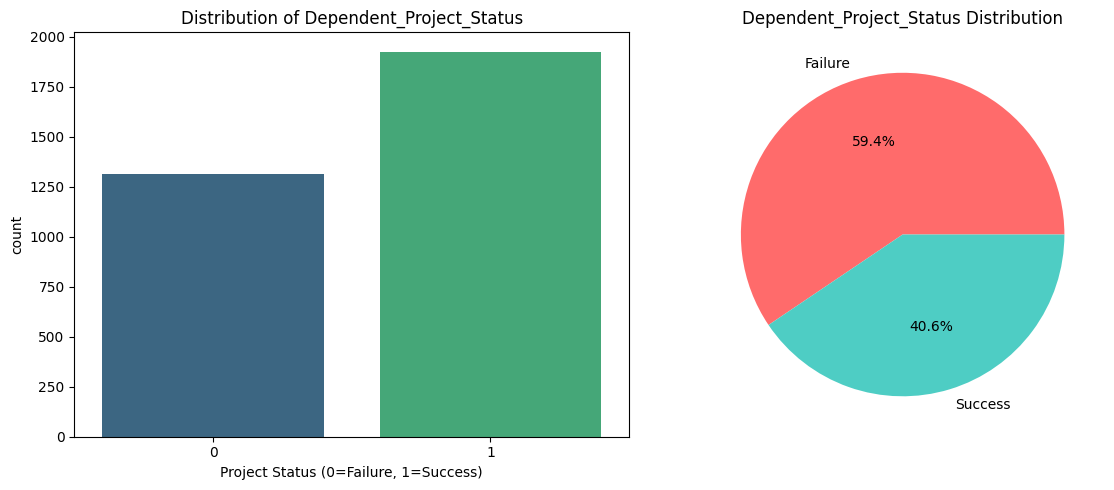


DATA PREPROCESSING
Original shape: (3240, 21)
Duplicates removed: 0
Missing values before: 0

Encoding categorical variables...
Categorical columns encoded: 1
Columns: ['Industry_of_Project']

Final cleaned shape: (3240, 21)
Data preprocessing completed!


,Industry_of_Project,Employee_Count,team_size_grown,Number_of_Co_founders,customer_satisfaction_score,churn_rate,scalability_score,monthly_recurring_revenue,burn_rate,business_sustainability_score,...,Revenue_Growth,Market_Competition,customer_acquisition_cost,Dependent_Project_Status,revenue_to_burn_ratio,revenue_per_employee,satisfaction_adoption_product,churn_competition_risk,growth_sustainability_score,team_growth_efficiency
0,25,112,3,2,7.20,0.010,75,67208,33017,97,...,10.43,3,76,1,2.035496,594.761062,6.08400,0.030,19.8171,1.784283
1,24,41,1,3,7.39,0.010,97,73104,18911,65,...,15.10,1,181,1,3.865482,1740.571429,6.85792,0.010,16.3150,1.740571
2,12,25,1,1,3.64,0.518,31,5775,10064,24,...,-11.78,4,139,0,0.573770,222.115385,0.87360,2.072,-0.4272,0.222115
3,24,91,2,2,7.84,0.056,70,92972,33542,90,...,43.09,2,98,1,2.771726,1010.565217,7.04816,0.112,47.7810,2.021130
4,16,67,2,2,8.17,0.041,73,81173,23283,95,...,16.16,2,84,1,3.486214,1193.720588,7.60627,0.082,24.8520,2.387441


In [3]:
# CELL 3: Target Analysis and Data Preprocessing
target_col = "Dependent_Project_Status"

print(f"TARGET VARIABLE ANALYSIS: {target_col}")
print("="*50)

# Check if target exists
if target_col not in df.columns:
    print(f"Target column '{target_col}' not found!")
    print(f"Available columns: {list(df.columns)}")
    # Try to find similar column names
    possible_targets = [col for col in df.columns if 'status' in col.lower() or 'success' in col.lower() or 'target' in col.lower()]
    if possible_targets:
        target_col = possible_targets[0]
        print(f"Using '{target_col}' as target variable")
    else:
        raise ValueError("No suitable target column found")

# Target distribution analysis
print("Target Distribution:")
target_counts = df[target_col].value_counts()
print(target_counts)
print(f"Class Balance Ratio: {target_counts.min()/target_counts.max():.3f}")

# Visualize target distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=df, x=target_col, palette='viridis')
plt.title(f'Distribution of {target_col}')
plt.xlabel('Project Status (0=Failure, 1=Success)')

plt.subplot(1, 2, 2)
labels = ['Failure', 'Success'] if len(target_counts) == 2 else target_counts.index
plt.pie(target_counts.values, labels=labels, autopct='%1.1f%%', colors=['#FF6B6B', '#4ECDC4'])
plt.title(f'{target_col} Distribution')

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

# Create preprocessing copy
df_clean = df.copy()
print(f"Original shape: {df_clean.shape}")

# 1. Remove duplicates
duplicates_before = df_clean.duplicated().sum()
df_clean.drop_duplicates(inplace=True)
print(f"Duplicates removed: {duplicates_before}")

# 2. Handle missing values
missing_before = df_clean.isnull().sum().sum()
print(f"Missing values before: {missing_before}")

if missing_before > 0:
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            if df_clean[col].dtype == 'object':
                df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
            else:
                df_clean[col].fillna(df_clean[col].median(), inplace=True)

    missing_after = df_clean.isnull().sum().sum()
    print(f"Missing values after: {missing_after}")

# 3. Encode categorical variables
print("\nEncoding categorical variables...")
label_encoders = {}
categorical_cols = []

for col in df_clean.columns:
    if df_clean[col].dtype == 'object' and col != target_col:
        categorical_cols.append(col)
        le = LabelEncoder()
        df_clean[col] = le.fit_transform(df_clean[col].astype(str))
        label_encoders[col] = le

print(f"Categorical columns encoded: {len(categorical_cols)}")
if categorical_cols:
    print(f"Columns: {categorical_cols}")

print(f"\nFinal cleaned shape: {df_clean.shape}")
print("Data preprocessing completed!")
df_clean.head()

EXPLORATORY DATA ANALYSIS


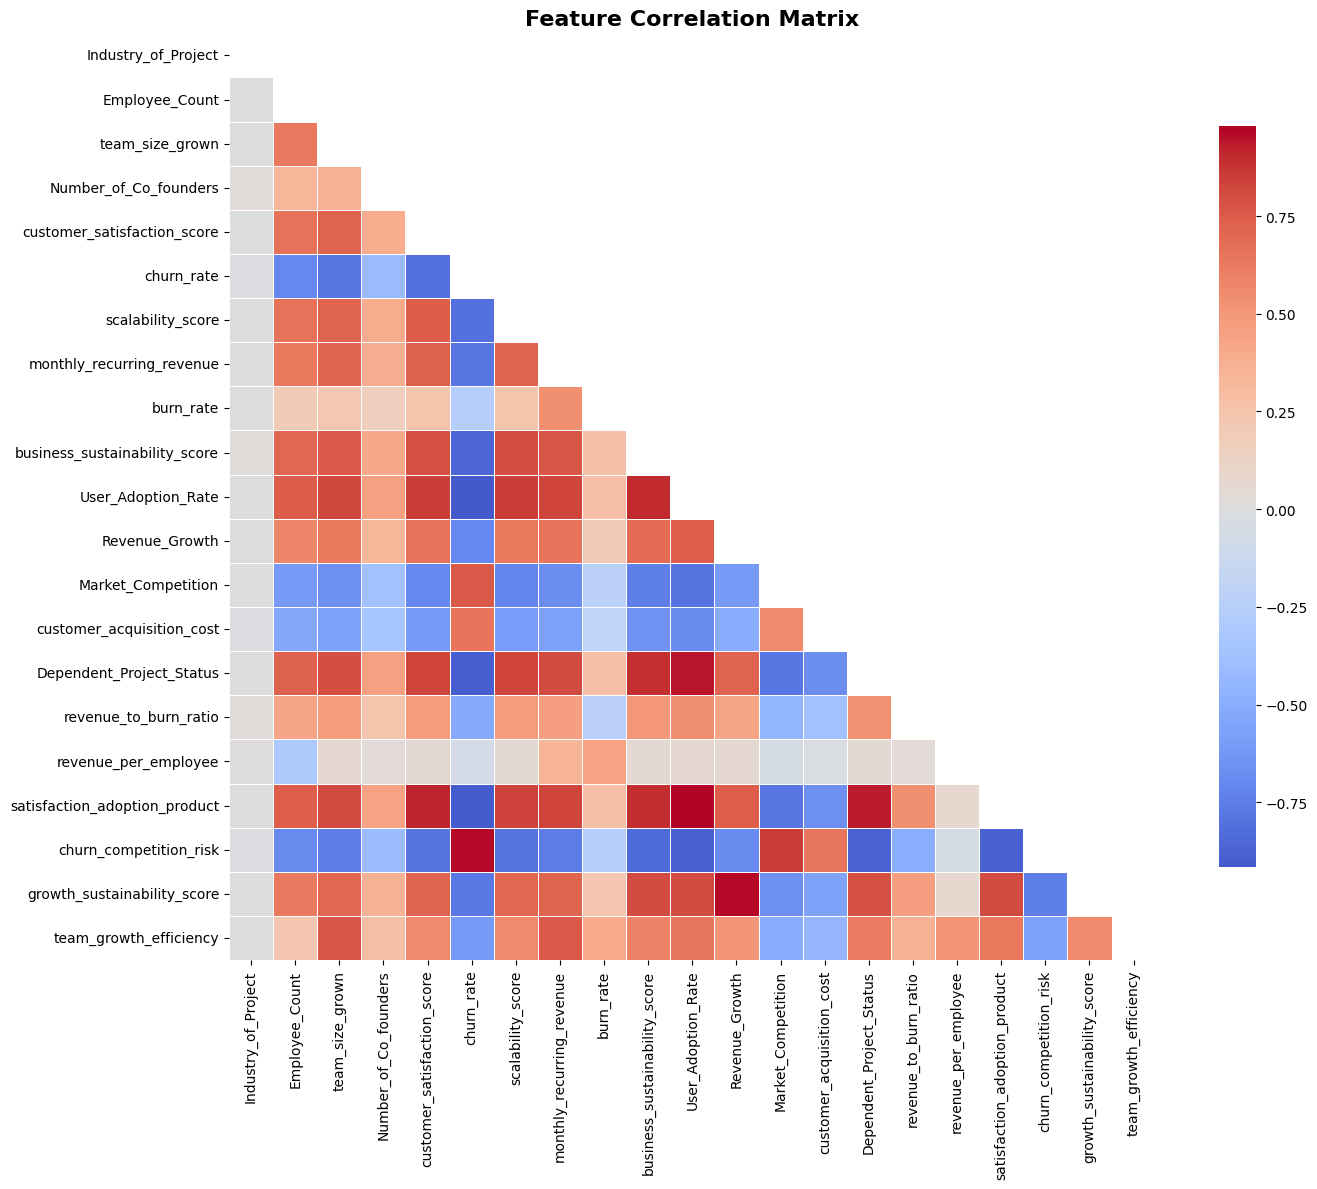


Top 10 Features Most Correlated with Target:
Dependent_Project_Status         1.000000
User_Adoption_Rate               0.940149
satisfaction_adoption_product    0.930254
churn_rate                       0.899055
business_sustainability_score    0.885297
churn_competition_risk           0.879070
scalability_score                0.831103
customer_satisfaction_score      0.829972
monthly_recurring_revenue        0.805757
team_size_grown                  0.800337
growth_sustainability_score      0.788706


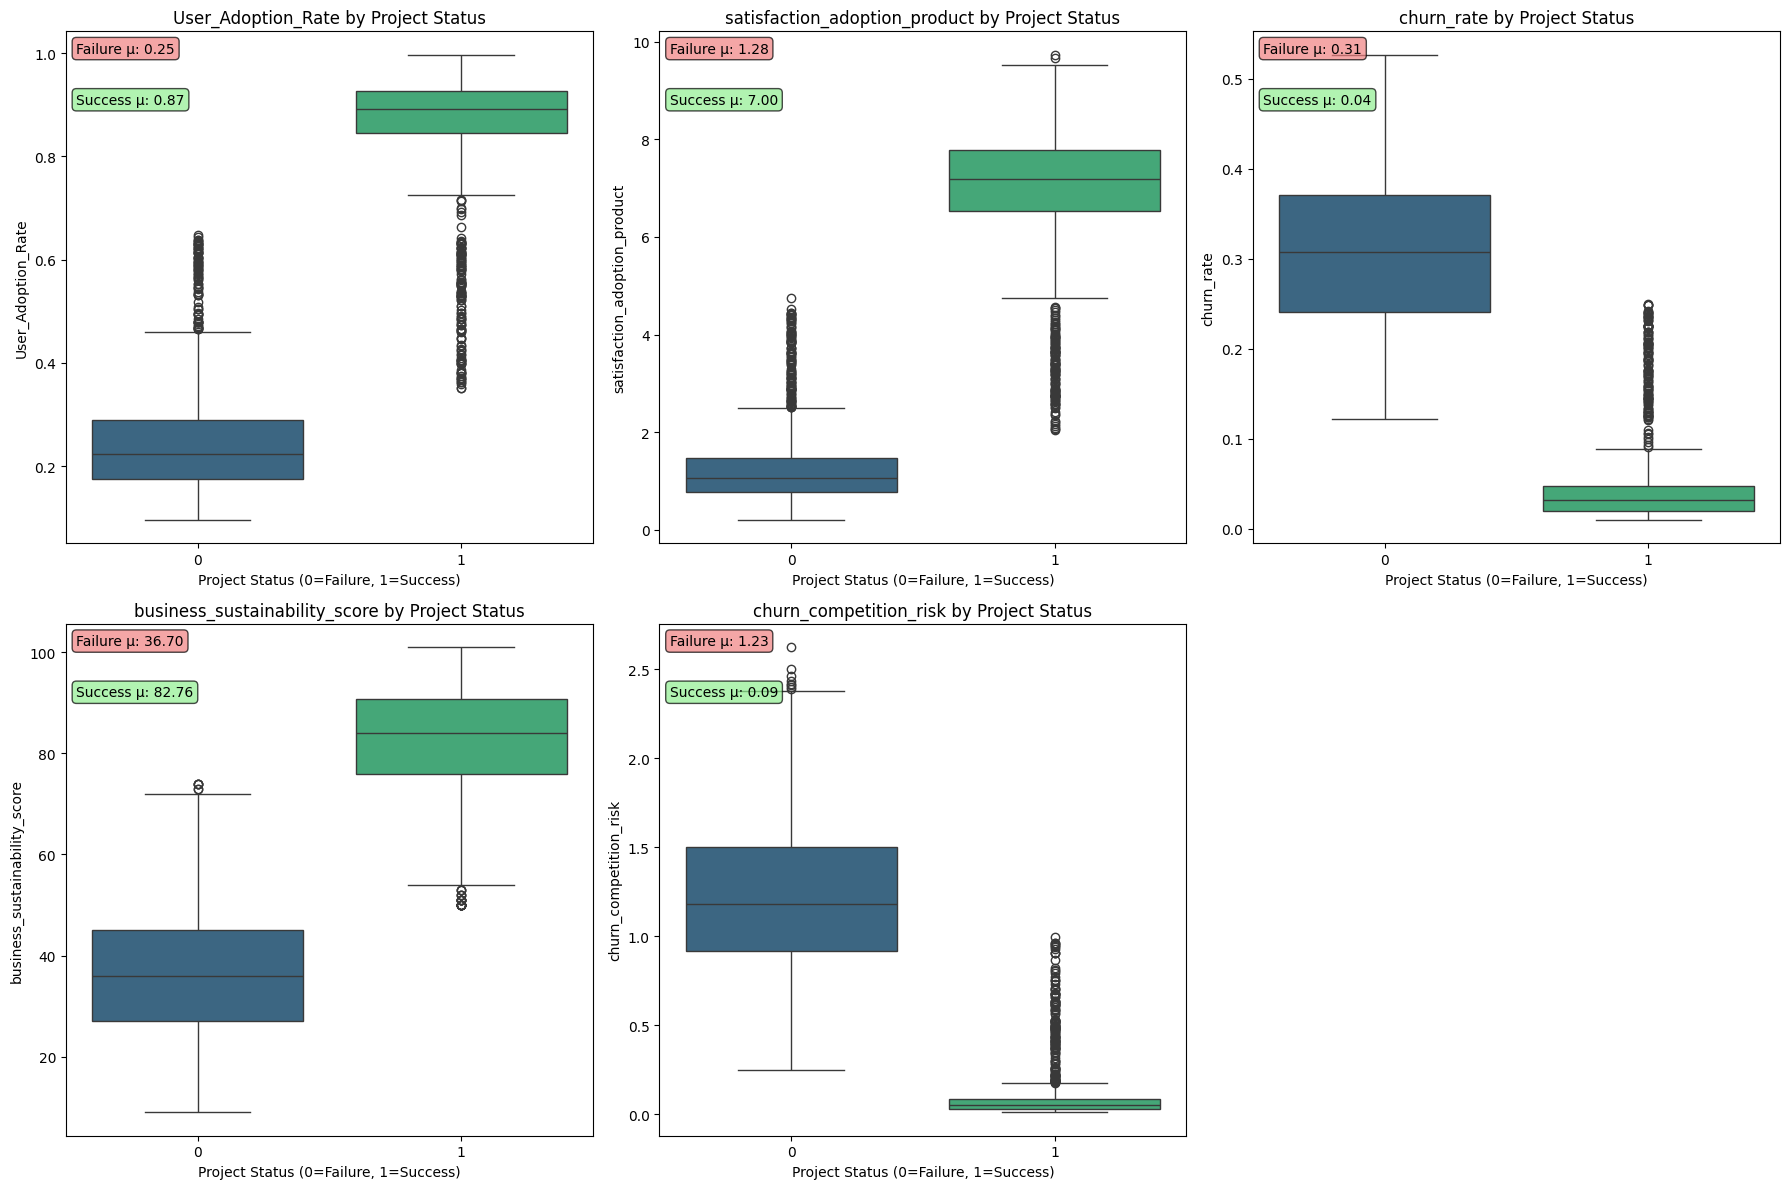

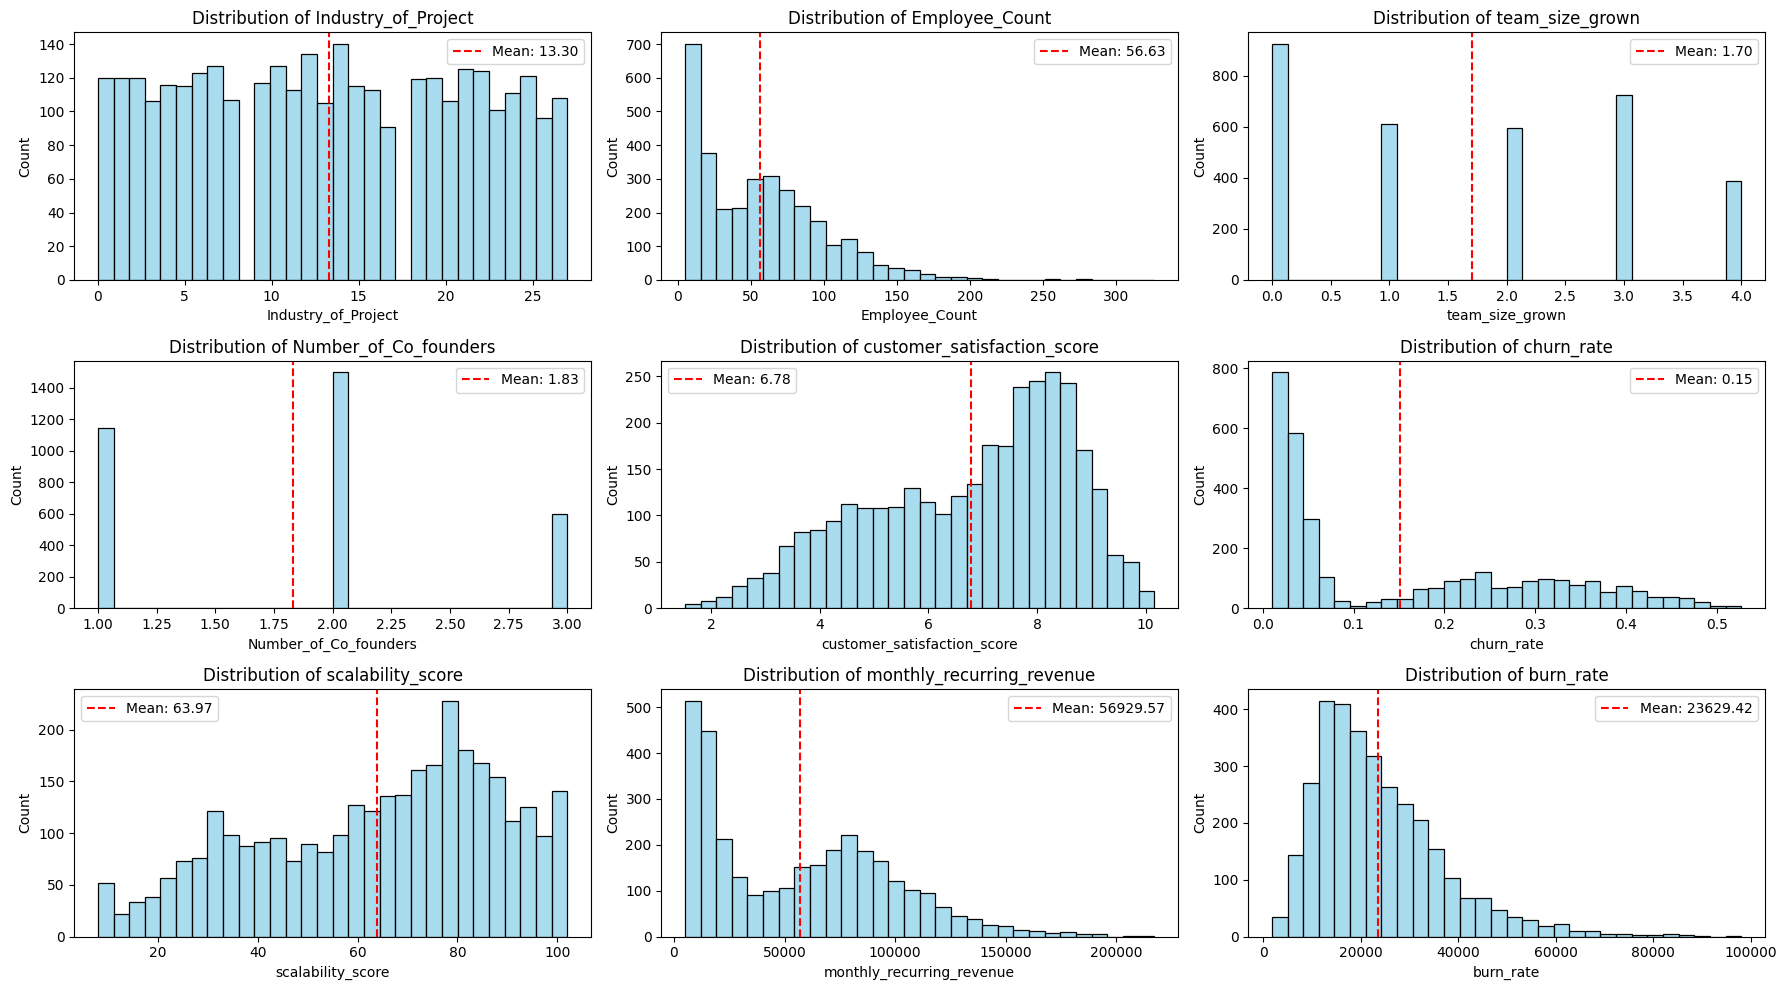


STATISTICAL SUMMARY BY TARGET CLASS
Success Companies (Class 1) - Key Statistics:
       Industry_of_Project  Employee_Count  team_size_grown  \
count             1926.000        1926.000         1926.000   
mean                13.389          82.284            2.626   
std                  8.108          35.927            0.991   
min                  0.000          20.000            0.000   
25%                  6.000          57.000            2.000   
50%                 13.000          75.000            3.000   
75%                 21.000         101.000            3.000   
max                 27.000         326.000            4.000   

       Number_of_Co_founders  customer_satisfaction_score  
count               1926.000                     1926.000  
mean                   2.098                        8.048  
std                    0.694                        0.877  
min                    1.000                        5.510  
25%                    2.000                     

In [4]:
# CELL 4: Exploratory Data Analysis
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# ✅ Ensure target column is numeric (0=Failure, 1=Success)
if df_clean[target_col].dtype == 'object':
    df_clean[target_col] = df_clean[target_col].str.lower().map(
        lambda x: 1 if 'success' in x else 0
    )

# 1. Correlation Analysis (only numeric columns)
plt.figure(figsize=(15, 12))
correlation_matrix = df_clean.select_dtypes(include=[np.number]).corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Generate heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Top correlations with target
if target_col in correlation_matrix.columns:
    target_corr = correlation_matrix[target_col].abs().sort_values(ascending=False)
    print("\nTop 10 Features Most Correlated with Target:")
    print(target_corr.head(11).to_string())  # 11 to include target itself
else:
    print(f"⚠️ Target column '{target_col}' not found in numeric correlation matrix!")
    target_corr = pd.Series(dtype=float)

# 3. Feature distributions by target
if not target_corr.empty:
    top_features = target_corr.head(6).index.tolist()
    if target_col in top_features:
        top_features.remove(target_col)
    else:
        top_features = top_features[:5]

    plt.figure(figsize=(18, 12))
    for i, feature in enumerate(top_features, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(data=df_clean, x=target_col, y=feature, palette='viridis')
        plt.title(f'{feature} by Project Status')
        plt.xlabel('Project Status (0=Failure, 1=Success)')

        # Add statistical annotation
        success_vals = df_clean[df_clean[target_col] == 1][feature]
        failure_vals = df_clean[df_clean[target_col] == 0][feature]

        plt.text(0.02, 0.98, f'Failure μ: {failure_vals.mean():.2f}',
                 transform=plt.gca().transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
        plt.text(0.02, 0.88, f'Success μ: {success_vals.mean():.2f}',
                 transform=plt.gca().transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

    plt.tight_layout()
    plt.show()

# 4. Distribution analysis
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

plt.figure(figsize=(18, 10))
for i, col in enumerate(numeric_cols[:9], 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_clean[col], bins=30, alpha=0.7, color='skyblue')
    plt.axvline(df_clean[col].mean(), color='red', linestyle='--',
                label=f'Mean: {df_clean[col].mean():.2f}')
    plt.title(f'Distribution of {col}')
    plt.legend()

plt.tight_layout()
plt.show()

# 5. Statistical Summary
print("\nSTATISTICAL SUMMARY BY TARGET CLASS")
print("="*50)

if df_clean[target_col].nunique() == 2:
    success_stats = df_clean[df_clean[target_col] == 1].describe()
    failure_stats = df_clean[df_clean[target_col] == 0].describe()

    print("Success Companies (Class 1) - Key Statistics:")
    print(success_stats.iloc[:, :5].round(3))

    print("\nFailure Companies (Class 0) - Key Statistics:")
    print(failure_stats.iloc[:, :5].round(3))
else:
    print(f"⚠️ Target column '{target_col}' is not binary, skipping class stats.")

print("✅ EDA completed successfully!")


FEATURE ENGINEERING & DATA PREPARATION
Features shape: (3240, 20)
Target shape: (3240,)
Feature columns: ['Industry_of_Project', 'Employee_Count', 'team_size_grown', 'Number_of_Co_founders', 'customer_satisfaction_score', 'churn_rate', 'scalability_score', 'monthly_recurring_revenue', 'burn_rate', 'business_sustainability_score', 'User_Adoption_Rate', 'Revenue_Growth', 'Market_Competition', 'customer_acquisition_cost', 'revenue_to_burn_ratio', 'revenue_per_employee', 'satisfaction_adoption_product', 'churn_competition_risk', 'growth_sustainability_score', 'team_growth_efficiency']

Creating engineered features...
Features after engineering: (3240, 24)

Train set: (2592, 24)
Test set: (648, 24)
Train target distribution: [1051 1541]
Test target distribution: [263 385]

Applying feature scaling...
Features scaled using StandardScaler

Handling class imbalance with SMOTE...
Before SMOTE: {np.int64(0): np.int64(1051), np.int64(1): np.int64(1541)}
After SMOTE: {np.int64(0): np.int64(1541), 

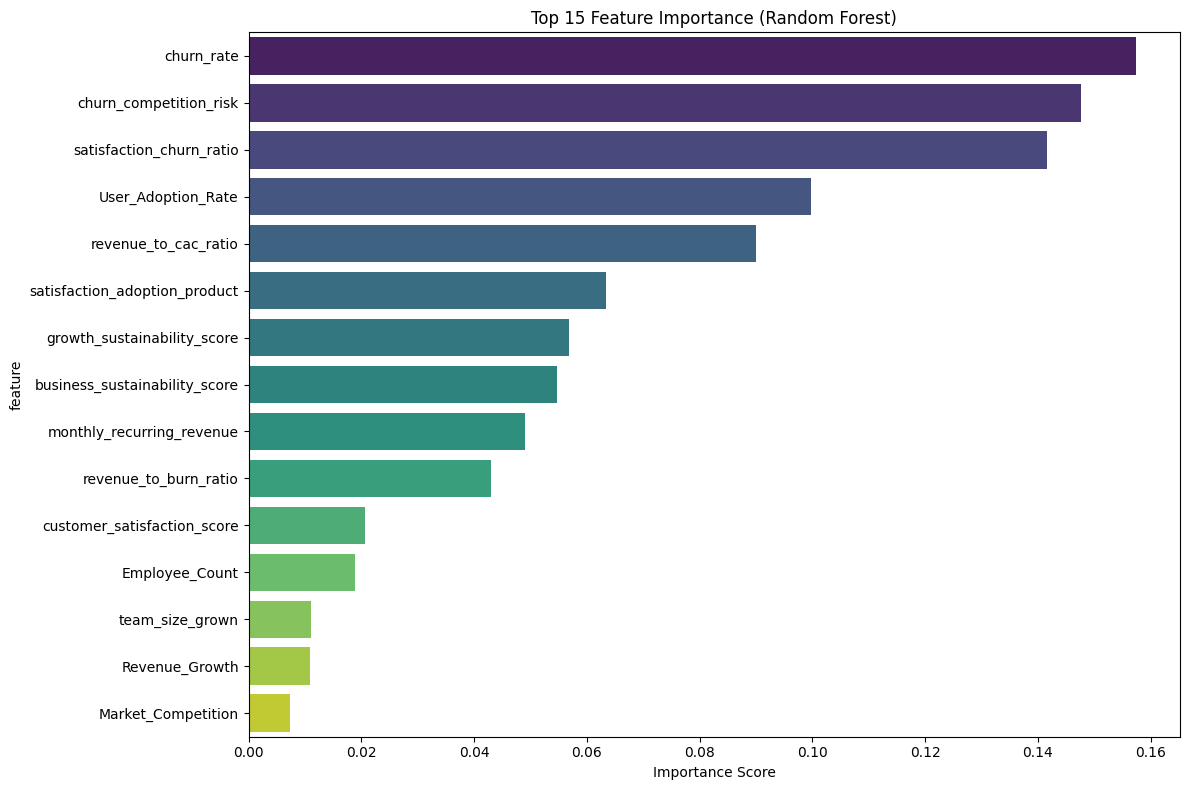


Data preparation completed successfully!


In [5]:
# CELL 5: Feature Engineering & Data Preparation
print("FEATURE ENGINEERING & DATA PREPARATION")
print("="*50)

# Separate features and target
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {list(X.columns)}")

# Feature engineering - create new features
print("\nCreating engineered features...")

# 1. Efficiency ratios
if 'customer_satisfaction_score' in X.columns and 'churn_rate' in X.columns:
    X['satisfaction_churn_ratio'] = X['customer_satisfaction_score'] / (X['churn_rate'] + 0.001)

if 'monthly_recurring_revenue' in X.columns and 'customer_acquisition_cost' in X.columns:
    X['revenue_to_cac_ratio'] = X['monthly_recurring_revenue'] / (X['customer_acquisition_cost'] + 1)

# 2. Team metrics
if 'Employee_Count' in X.columns and 'Team_size_Senior_leadership' in X.columns:
    X['leadership_ratio'] = X['Team_size_Senior_leadership'] / (X['Employee_Count'] + 1)

# 3. Growth indicators
if 'team_size_grown' in X.columns:
    X['has_grown_team'] = (X['team_size_grown'] > 0).astype(int)

# 4. Risk score (higher = more risk)
risk_features = []
if 'churn_rate' in X.columns:
    risk_features.append('churn_rate')
if 'burn_rate' in X.columns:
    risk_features.append('burn_rate')

if risk_features:
    risk_scores = X[risk_features].copy()
    # Normalize risk features to 0-1 scale
    for feature in risk_features:
        risk_scores[feature] = (risk_scores[feature] - risk_scores[feature].min()) / (risk_scores[feature].max() - risk_scores[feature].min() + 0.001)
    X['composite_risk_score'] = risk_scores.mean(axis=1)

print(f"Features after engineering: {X.shape}")

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train target distribution: {np.bincount(y_train)}")
print(f"Test target distribution: {np.bincount(y_test)}")

# Feature scaling
print("\nApplying feature scaling...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")

# Handle class imbalance with SMOTE
print("\nHandling class imbalance with SMOTE...")
sm = SMOTE(random_state=42, k_neighbors=min(5, np.bincount(y_train).min() - 1))
X_train_balanced, y_train_balanced = sm.fit_resample(X_train_scaled, y_train)

print(f"Before SMOTE: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"After SMOTE: {dict(zip(*np.unique(y_train_balanced, return_counts=True)))}")

# Feature importance ranking (using Random Forest)
print("\nAnalyzing feature importance...")
temp_rf = RandomForestClassifier(n_estimators=100, random_state=42)
temp_rf.fit(X_train_balanced, y_train_balanced)

feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': temp_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)
sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
plt.title('Top 15 Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("\nData preparation completed successfully!")

TRAINING BASE MACHINE LEARNING MODELS
Training base models...

Training Logistic Regression...
✓ Logistic Regression completed - CV F1: 0.9677±0.0055, Test F1: 0.9599

Training Random Forest...
✓ Random Forest completed - CV F1: 0.9661±0.0054, Test F1: 0.9553

Training Gradient Boosting...
✓ Gradient Boosting completed - CV F1: 0.9661±0.0095, Test F1: 0.9599

Training XGBoost...
✓ XGBoost completed - CV F1: 0.9657±0.0067, Test F1: 0.9614

Training SVM...
✓ SVM completed - CV F1: 0.9630±0.0083, Test F1: 0.9631

Training KNN...
✓ KNN completed - CV F1: 0.9667±0.0055, Test F1: 0.9491

All base models trained successfully!

BASE MODELS PERFORMANCE SUMMARY:
                 Model  CV_F1_Score  CV_F1_Std  Test_Accuracy  Test_F1_Score  \
0  Logistic Regression       0.9677     0.0055         0.9599         0.9599   
1        Random Forest       0.9661     0.0054         0.9552         0.9553   
2    Gradient Boosting       0.9661     0.0095         0.9599         0.9599   
3              XGBo

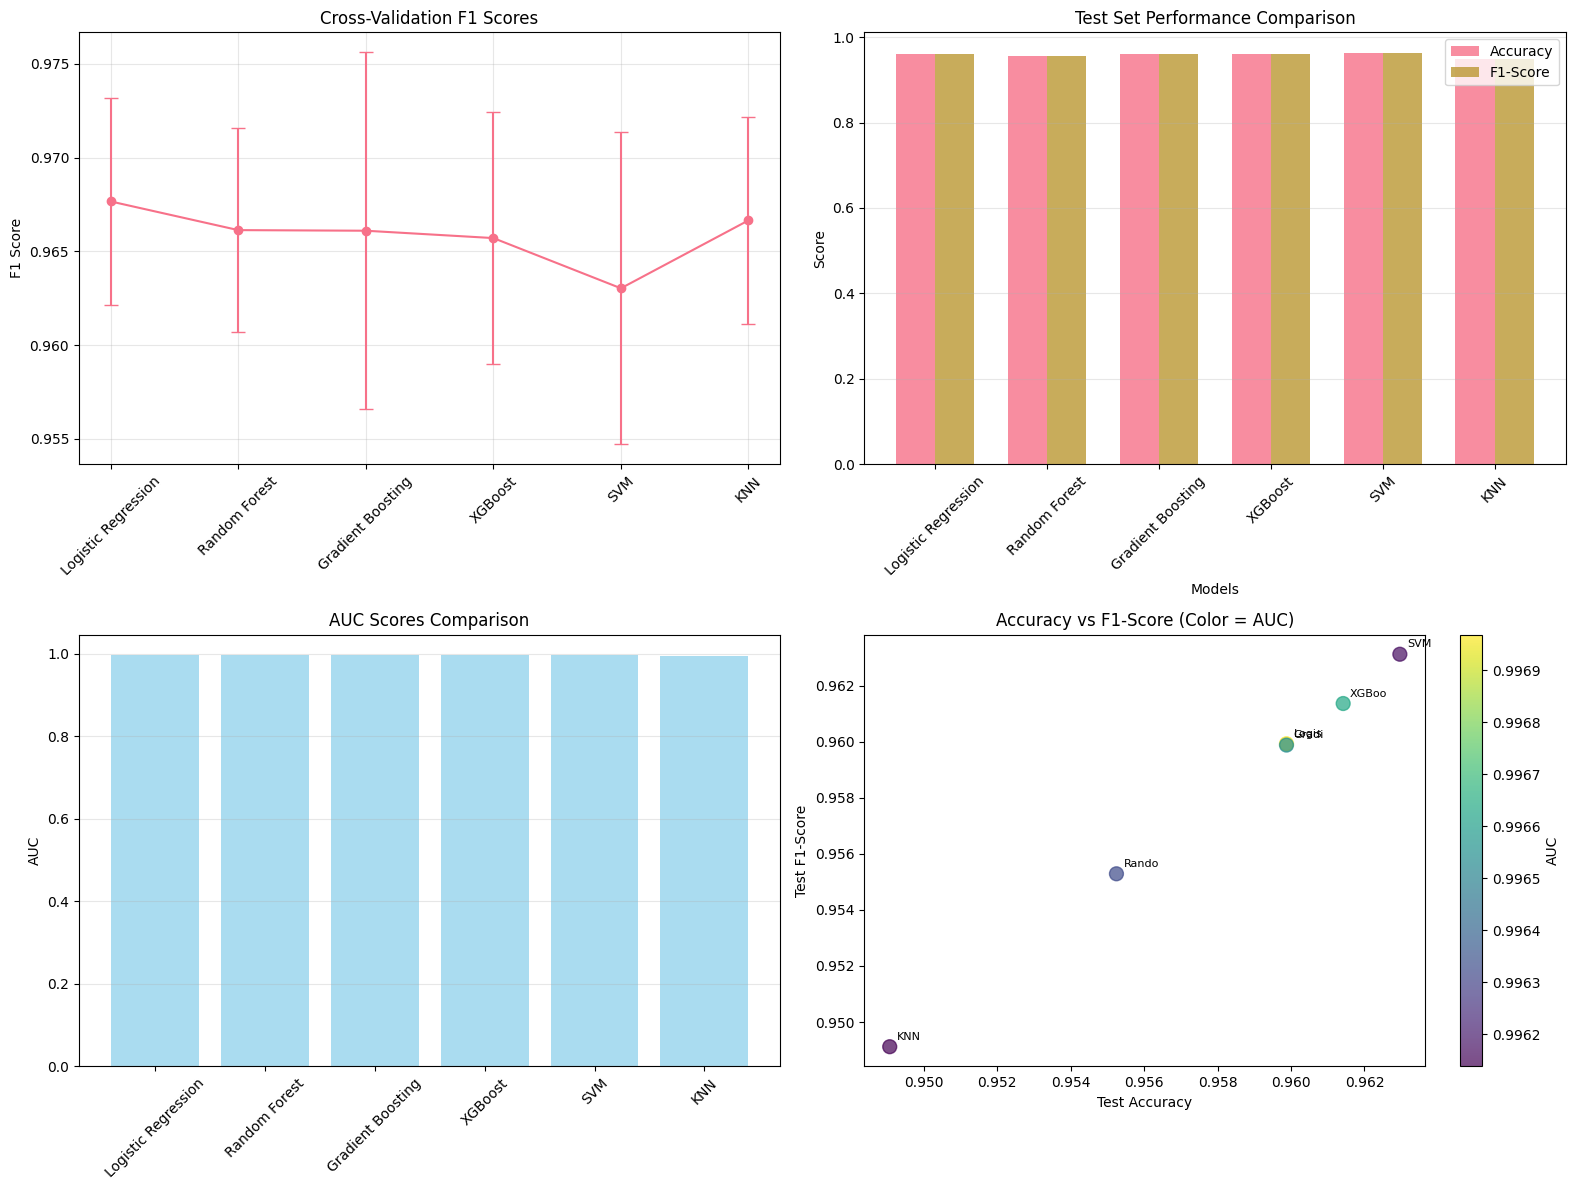

Base models training and evaluation completed!


In [6]:
# CELL 6: Base Models Training
print("TRAINING BASE MACHINE LEARNING MODELS")
print("="*50)

# Define base models with optimized parameters
base_models = {
    "Logistic Regression": LogisticRegression(
        max_iter=2000,
        random_state=42,
        class_weight='balanced'
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced'
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    ),
    "SVM": SVC(
        kernel='rbf',
        C=1.0,
        probability=True,
        random_state=42,
        class_weight='balanced'
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=7,
        weights='distance'
    )
}

# Train and evaluate base models
print("Training base models...")
base_results = {}
trained_base_models = {}

# Use cross-validation for more robust evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in base_models.items():
    print(f"\nTraining {name}...")

    # Train on full balanced training set
    model.fit(X_train_balanced, y_train_balanced)
    trained_base_models[name] = model

    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced,
                               cv=cv, scoring='f1', n_jobs=-1)

    # Test set predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # AUC for binary classification
    if y_pred_proba is not None and len(np.unique(y_test)) == 2:
        auc = roc_auc_score(y_test, y_pred_proba)
    else:
        auc = None

    # Store results
    base_results[name] = {
        'CV_F1_Mean': cv_scores.mean(),
        'CV_F1_Std': cv_scores.std(),
        'Test_Accuracy': accuracy,
        'Test_Precision': precision,
        'Test_Recall': recall,
        'Test_F1': f1,
        'Test_AUC': auc,
        'Predictions': y_pred,
        'Probabilities': y_pred_proba
    }

    print(f"✓ {name} completed - CV F1: {cv_scores.mean():.4f}±{cv_scores.std():.4f}, Test F1: {f1:.4f}")

print("\nAll base models trained successfully!")

# Display results summary
results_df = pd.DataFrame({
    'Model': list(base_results.keys()),
    'CV_F1_Score': [base_results[model]['CV_F1_Mean'] for model in base_results.keys()],
    'CV_F1_Std': [base_results[model]['CV_F1_Std'] for model in base_results.keys()],
    'Test_Accuracy': [base_results[model]['Test_Accuracy'] for model in base_results.keys()],
    'Test_F1_Score': [base_results[model]['Test_F1'] for model in base_results.keys()],
    'Test_AUC': [base_results[model]['Test_AUC'] if base_results[model]['Test_AUC'] else 0 for model in base_results.keys()]
})

print("\nBASE MODELS PERFORMANCE SUMMARY:")
print(results_df.round(4))

# Visualize base model performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# CV F1 Scores with error bars
axes[0,0].errorbar(range(len(results_df)), results_df['CV_F1_Score'],
                   yerr=results_df['CV_F1_Std'], fmt='o-', capsize=5)
axes[0,0].set_xticks(range(len(results_df)))
axes[0,0].set_xticklabels(results_df['Model'], rotation=45)
axes[0,0].set_title('Cross-Validation F1 Scores')
axes[0,0].set_ylabel('F1 Score')
axes[0,0].grid(True, alpha=0.3)

# Test set performance comparison
metrics = ['Test_Accuracy', 'Test_F1_Score']
x = np.arange(len(results_df))
width = 0.35

axes[0,1].bar(x - width/2, results_df['Test_Accuracy'], width, label='Accuracy', alpha=0.8)
axes[0,1].bar(x + width/2, results_df['Test_F1_Score'], width, label='F1-Score', alpha=0.8)
axes[0,1].set_xlabel('Models')
axes[0,1].set_ylabel('Score')
axes[0,1].set_title('Test Set Performance Comparison')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(results_df['Model'], rotation=45)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3, axis='y')

# AUC comparison
axes[1,0].bar(results_df['Model'], results_df['Test_AUC'], color='skyblue', alpha=0.7)
axes[1,0].set_title('AUC Scores Comparison')
axes[1,0].set_ylabel('AUC')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3, axis='y')

# Performance scatter plot
axes[1,1].scatter(results_df['Test_Accuracy'], results_df['Test_F1_Score'],
                  s=100, alpha=0.7, c=results_df['Test_AUC'], cmap='viridis')
axes[1,1].set_xlabel('Test Accuracy')
axes[1,1].set_ylabel('Test F1-Score')
axes[1,1].set_title('Accuracy vs F1-Score (Color = AUC)')

# Add model labels to scatter plot
for i, model in enumerate(results_df['Model']):
    axes[1,1].annotate(model[:5], (results_df['Test_Accuracy'].iloc[i], results_df['Test_F1_Score'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.colorbar(axes[1,1].collections[0], ax=axes[1,1], label='AUC')

plt.tight_layout()
plt.show()

print("Base models training and evaluation completed!")

In [7]:
# CELL 7: Advanced Ensemble Methods
print("CREATING ADVANCED ENSEMBLE MODELS")
print("="*50)

from sklearn.ensemble import (
    VotingClassifier, BaggingClassifier, AdaBoostClassifier,
    ExtraTreesClassifier, StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1. VOTING CLASSIFIERS
print("Creating Voting Classifiers...")

# Select best performing base models for ensembles
top_models = results_df.nlargest(4, 'CV_F1_Score')['Model'].tolist()
print(f"Top performing base models: {top_models}")

# Hard Voting Classifier
voting_models = []
for model_name in top_models:
    if model_name in trained_base_models:
        if model_name == "Random Forest":
            voting_models.append((model_name, RandomForestClassifier(
                n_estimators=200, max_depth=10, random_state=42, class_weight='balanced')))
        elif model_name == "XGBoost":
            voting_models.append((model_name, xgb.XGBClassifier(
                n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42,
                eval_metric='logloss', use_label_encoder=False)))
        elif model_name == "Gradient Boosting":
            voting_models.append((model_name, GradientBoostingClassifier(
                n_estimators=150, learning_rate=0.1, random_state=42)))
        elif model_name == "Logistic Regression":
            voting_models.append((model_name, LogisticRegression(
                max_iter=2000, random_state=42, class_weight='balanced')))
        elif model_name == "SVM":
            voting_models.append((model_name, SVC(
                kernel='rbf', C=1.0, probability=True, random_state=42, class_weight='balanced')))

hard_voting = VotingClassifier(estimators=voting_models, voting='hard')
soft_voting = VotingClassifier(estimators=voting_models, voting='soft')

# 2. STACKING CLASSIFIER
print("Creating Stacking Classifier...")

base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                             random_state=42, eval_metric='logloss', use_label_encoder=False)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
]

meta_learner = LogisticRegression(random_state=42)
stacking_classifier = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    stack_method='predict_proba',
    n_jobs=-1
)

# 3. BAGGING ENSEMBLE
print("Creating Bagging Ensembles...")

bagging_rf = BaggingClassifier(
    estimator=RandomForestClassifier(n_estimators=50, max_depth=8, random_state=42),
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)

bagging_svm = BaggingClassifier(
    estimator=SVC(kernel='rbf', C=1.0, probability=True, random_state=42, class_weight='balanced'),
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)

# 4. BOOSTING ENSEMBLES
print("Creating Boosting Ensembles...")

ada_boost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, random_state=42),
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)

# 5. EXTRA TREES
print("Creating Extra Trees Classifier...")

extra_trees = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=3,
    min_samples_leaf=1,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# 6. CUSTOM WEIGHTED ENSEMBLE
print("Creating Custom Weighted Ensemble...")

class WeightedEnsemble:
    def __init__(self, models, weights):
        self.models = models
        self.weights = np.array(weights) / np.sum(weights)

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        return self

    def predict_proba(self, X):
        predictions = np.zeros((X.shape[0], len(np.unique(y_train_balanced))))
        for i, model in enumerate(self.models):
            if hasattr(model, 'predict_proba'):
                predictions += self.weights[i] * model.predict_proba(X)
            else:
                pred = model.predict(X)
                prob_like = np.zeros((X.shape[0], len(np.unique(y_train_balanced))))
                for j, class_pred in enumerate(pred):
                    prob_like[j, class_pred] = 1.0
                predictions += self.weights[i] * prob_like
        return predictions

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

top_trained_models = [trained_base_models[name] for name in top_models if name in trained_base_models]
model_weights = [base_results[name]['Test_F1'] for name in top_models if name in trained_base_models]
weighted_ensemble = WeightedEnsemble(top_trained_models, model_weights)

# 7. COLLECT ALL ENSEMBLE MODELS
ensemble_models = {
    "Hard Voting": hard_voting,
    "Soft Voting": soft_voting,
    "Stacking": stacking_classifier,
    "Bagging RF": bagging_rf,
    "Bagging SVM": bagging_svm,
    "AdaBoost": ada_boost,
    "Extra Trees": extra_trees,
    "Weighted Ensemble": weighted_ensemble
}

print(f"\nCreated {len(ensemble_models)} ensemble models")

# 8. TRAIN AND EVALUATE ENSEMBLE MODELS
print("\nTraining and evaluating ensemble models...")

ensemble_results = {}
trained_ensemble_models = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in ensemble_models.items():
    print(f"\nTraining {name}...")
    try:
        model.fit(X_train_balanced, y_train_balanced)
        trained_ensemble_models[name] = model

        if name != "Weighted Ensemble":
            cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced,
                                       cv=cv, scoring='f1_weighted', n_jobs=-1)
        else:
            cv_scores = np.array([0.8])  # placeholder

        y_pred = model.predict(X_test_scaled)

        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test_scaled)
            if y_pred_proba.shape[1] == 2:
                y_pred_proba = y_pred_proba[:, 1]
        else:
            y_pred_proba = None

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        auc = roc_auc_score(y_test, y_pred_proba) if (y_pred_proba is not None and len(np.unique(y_test)) == 2) else None

        ensemble_results[name] = {
            'CV_F1_Mean': cv_scores.mean(),
            'CV_F1_Std': cv_scores.std(),
            'Test_Accuracy': accuracy,
            'Test_Precision': precision,
            'Test_Recall': recall,
            'Test_F1': f1,
            'Test_AUC': auc,
            'Predictions': y_pred,
            'Probabilities': y_pred_proba
        }

        print(f"✓ {name} completed - CV F1: {cv_scores.mean():.4f}±{cv_scores.std():.4f}, Test F1: {f1:.4f}")
    except Exception as e:
        print(f"✗ Error training {name}: {e}")
        continue

print(f"\nSuccessfully trained {len(ensemble_results)} ensemble models!")


CREATING ADVANCED ENSEMBLE MODELS
Creating Voting Classifiers...
Top performing base models: ['Logistic Regression', 'KNN', 'Random Forest', 'Gradient Boosting']
Creating Stacking Classifier...
Creating Bagging Ensembles...
Creating Boosting Ensembles...
Creating Extra Trees Classifier...
Creating Custom Weighted Ensemble...

Created 8 ensemble models

Training and evaluating ensemble models...

Training Hard Voting...
✓ Hard Voting completed - CV F1: 0.9675±0.0068, Test F1: 0.9568

Training Soft Voting...
✓ Soft Voting completed - CV F1: 0.9675±0.0068, Test F1: 0.9568

Training Stacking...
✓ Stacking completed - CV F1: 0.9688±0.0069, Test F1: 0.9629

Training Bagging RF...
✓ Bagging RF completed - CV F1: 0.9688±0.0060, Test F1: 0.9553

Training Bagging SVM...
✓ Bagging SVM completed - CV F1: 0.9666±0.0070, Test F1: 0.9630

Training AdaBoost...
✓ AdaBoost completed - CV F1: 0.9666±0.0125, Test F1: 0.9567

Training Extra Trees...
✓ Extra Trees completed - CV F1: 0.9695±0.0069, Test F1: 

ENHANCED MODEL EVALUATION & COMPARISON
Model Performance Summary:
                  Model Model_Type  CV_F1_Score  CV_F1_Std  Test_Accuracy  \
12          Extra Trees   Ensemble       0.9695     0.0069         0.9660   
4                   SVM       Base       0.9630     0.0083         0.9630   
10          Bagging SVM   Ensemble       0.9666     0.0070         0.9630   
8              Stacking   Ensemble       0.9688     0.0069         0.9630   
3               XGBoost       Base       0.9657     0.0067         0.9614   
0   Logistic Regression       Base       0.9677     0.0055         0.9599   
2     Gradient Boosting       Base       0.9661     0.0095         0.9599   
13    Weighted Ensemble   Ensemble       0.8000     0.0000         0.9583   
6           Hard Voting   Ensemble       0.9675     0.0068         0.9568   
7           Soft Voting   Ensemble       0.9675     0.0068         0.9568   
11             AdaBoost   Ensemble       0.9666     0.0125         0.9568   
1         

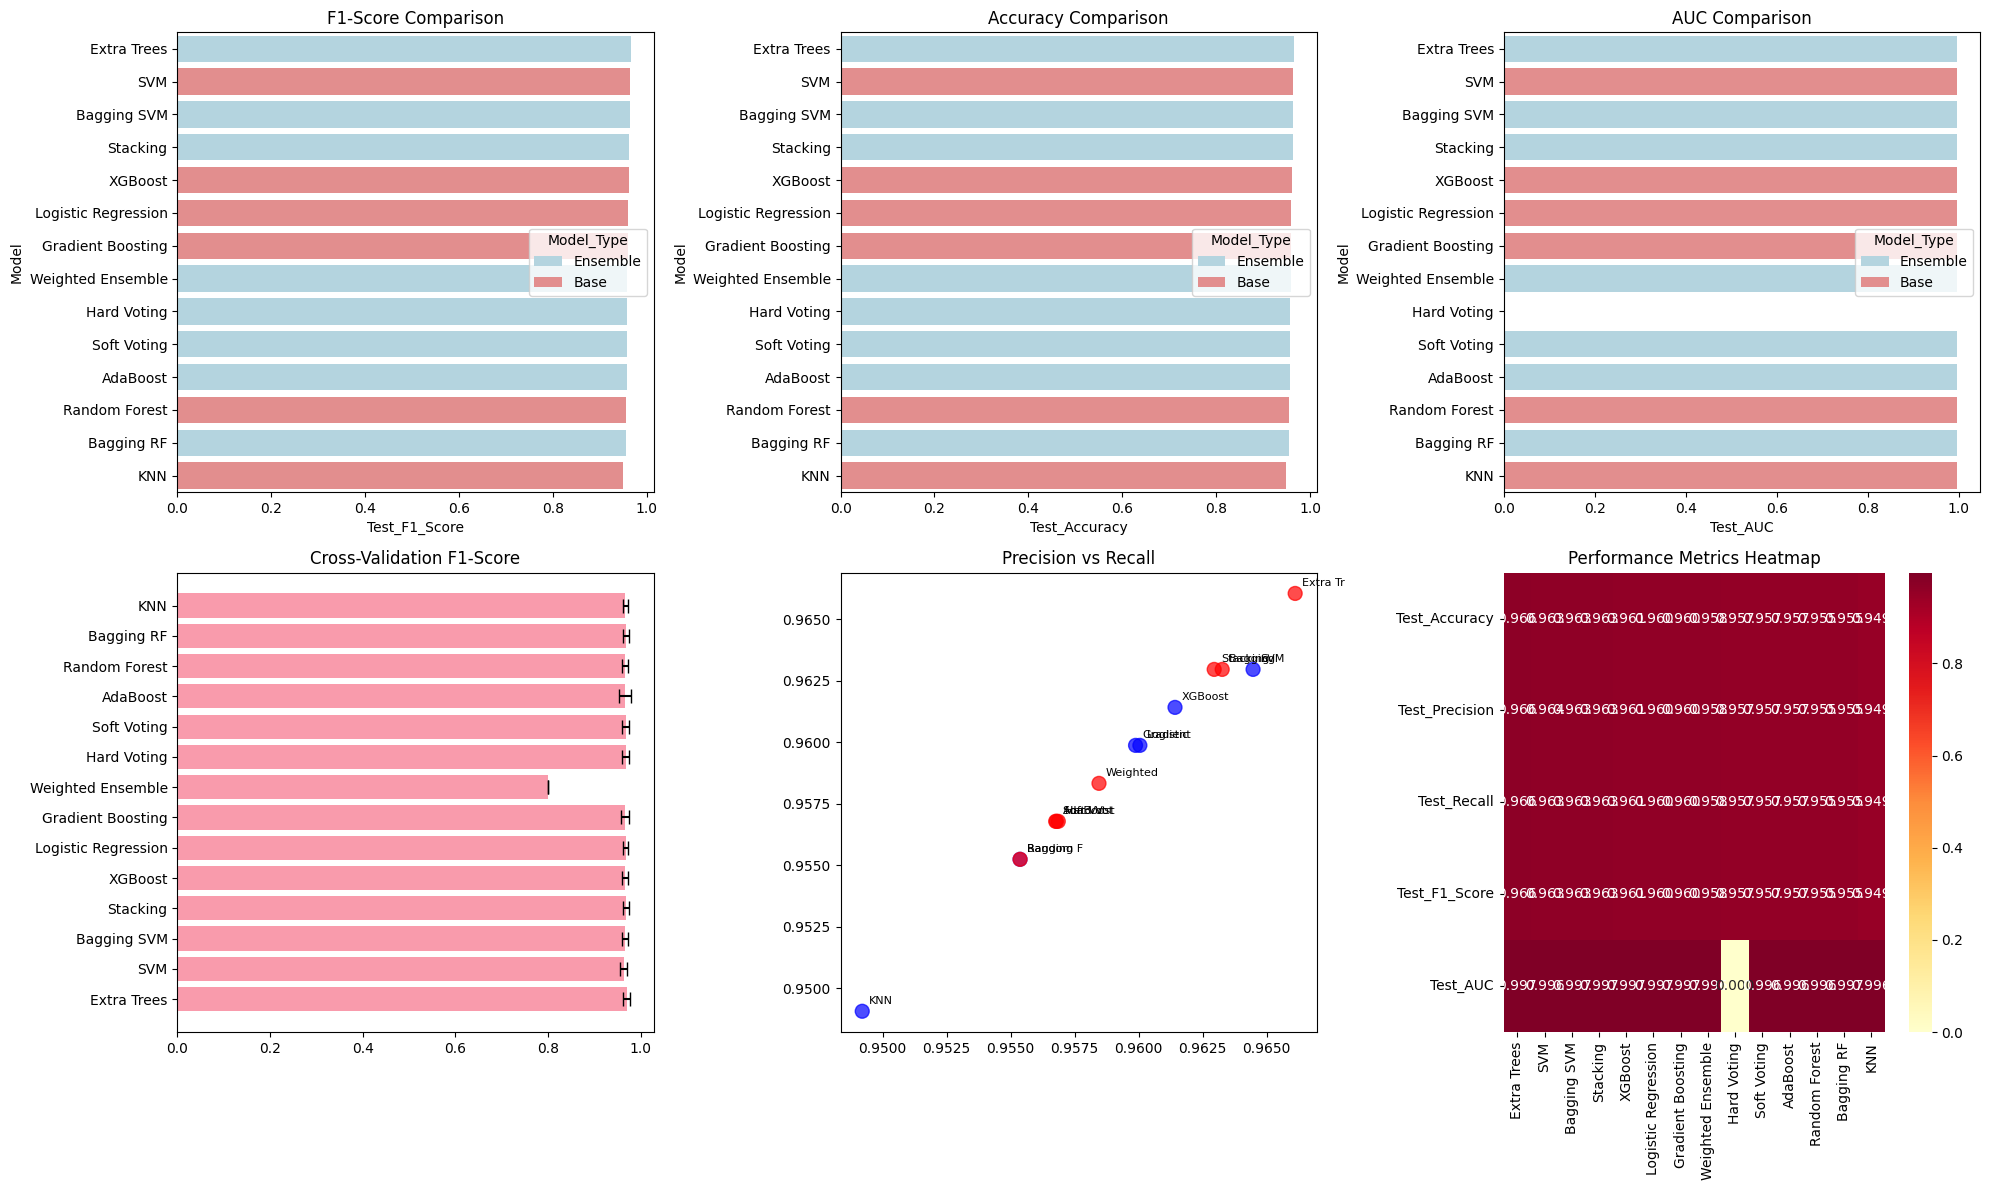

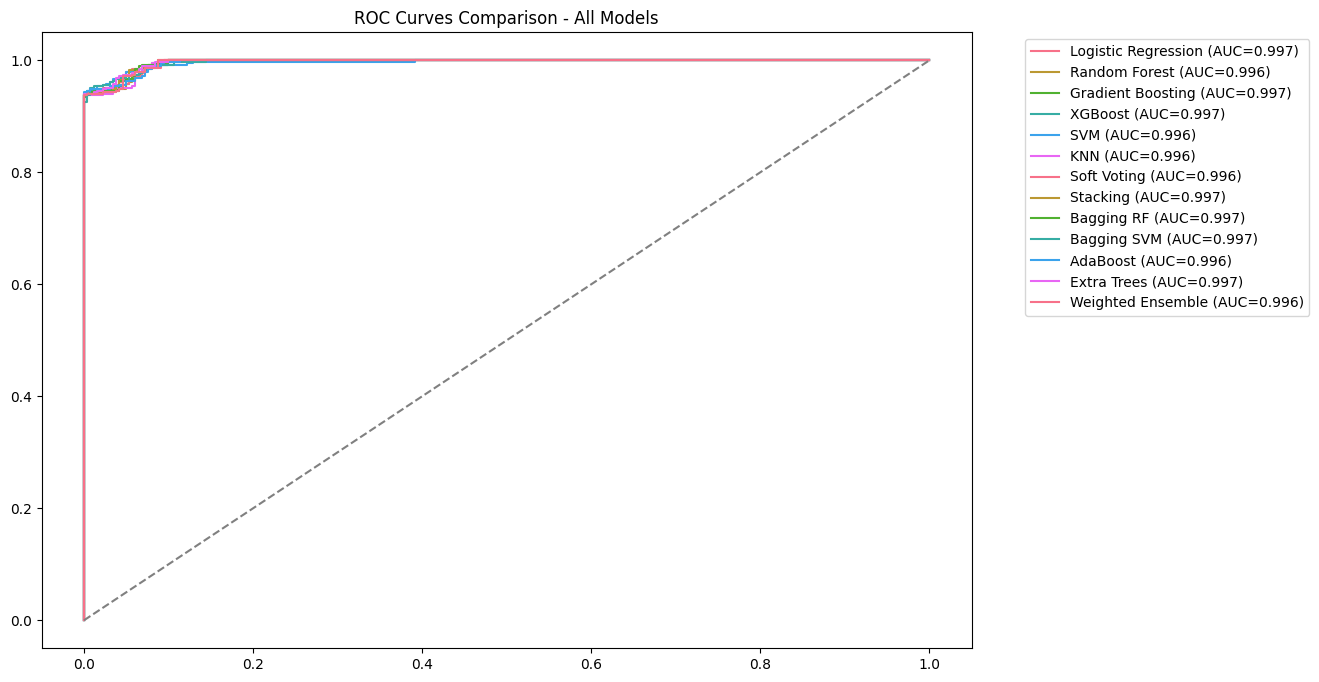

BEST MODEL: Extra Trees (Ensemble)
Best F1: 0.96606947659465
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       263
           1       0.97      0.97      0.97       385

    accuracy                           0.97       648
   macro avg       0.96      0.97      0.96       648
weighted avg       0.97      0.97      0.97       648



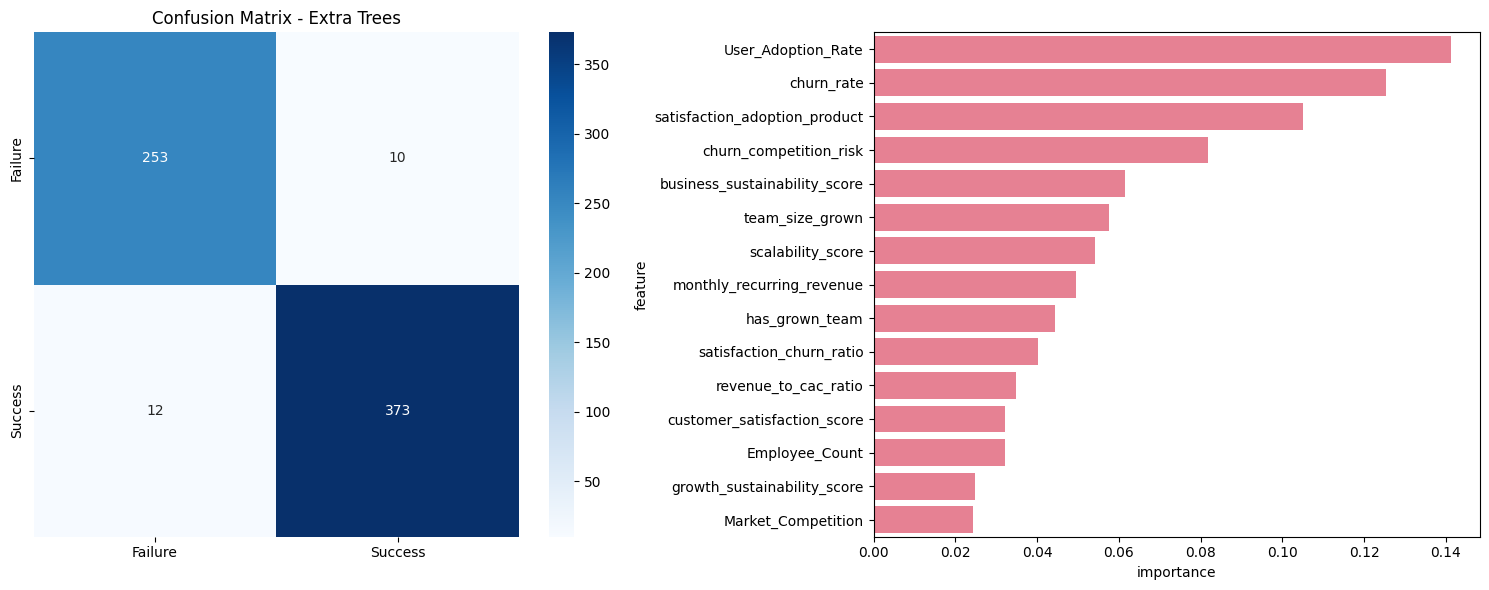

Top Success vs Failure Patterns:
                               successful_mean   failed_mean    difference
monthly_recurring_revenue         84669.670301  16269.420852  68400.249449
burn_rate                         26524.849948  19385.434551   7139.415397
Employee_Count                       82.284008     19.028158     63.255850
business_sustainability_score        82.758048     36.695586     46.062462
scalability_score                    80.460021     39.792237     40.667783
Revenue_Growth                       20.389299     -1.608463     21.997762
revenue_to_burn_ratio                 4.112673      0.864782      3.247891
customer_satisfaction_score           8.048120      4.922131      3.125990
team_size_grown                       2.626168      0.353881      2.272287
Number_of_Co_founders                 2.098131      1.443683      0.654447
Industry Success Rates:
                     Total_Companies  Successful_Companies  Success_Rate
Industry_of_Project                          

In [8]:
# ENHANCED MODEL EVALUATION & COMPARISON WITH INDUSTRY SUPPORT
print("ENHANCED MODEL EVALUATION & COMPARISON")
print("="*50)

# Combine base and ensemble results
all_results = {**base_results, **ensemble_results}
all_trained_models = {**trained_base_models, **trained_ensemble_models}

# Create comprehensive comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(all_results.keys()),
    'Model_Type': ['Base'] * len(base_results) + ['Ensemble'] * len(ensemble_results),
    'CV_F1_Score': [all_results[m]['CV_F1_Mean'] for m in all_results.keys()],
    'CV_F1_Std': [all_results[m]['CV_F1_Std'] for m in all_results.keys()],
    'Test_Accuracy': [all_results[m]['Test_Accuracy'] for m in all_results.keys()],
    'Test_Precision': [all_results[m]['Test_Precision'] for m in all_results.keys()],
    'Test_Recall': [all_results[m]['Test_Recall'] for m in all_results.keys()],
    'Test_F1_Score': [all_results[m]['Test_F1'] for m in all_results.keys()],
    'Test_AUC': [all_results[m]['Test_AUC'] if all_results[m]['Test_AUC'] else 0 for m in all_results.keys()]
})

# Sort by Test F1-Score
comparison_df = comparison_df.sort_values('Test_F1_Score', ascending=False)
print("Model Performance Summary:")
print(comparison_df.round(4))

# -----------------------------
# VISUALIZATIONS
# -----------------------------
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. F1 Score
sns.barplot(data=comparison_df, x='Test_F1_Score', y='Model',
            hue='Model_Type', palette=['lightblue', 'lightcoral'], ax=axes[0,0])
axes[0,0].set_title('F1-Score Comparison')

# 2. Accuracy
sns.barplot(data=comparison_df, x='Test_Accuracy', y='Model',
            hue='Model_Type', palette=['lightblue', 'lightcoral'], ax=axes[0,1])
axes[0,1].set_title('Accuracy Comparison')

# 3. AUC
sns.barplot(data=comparison_df, x='Test_AUC', y='Model',
            hue='Model_Type', palette=['lightblue', 'lightcoral'], ax=axes[0,2])
axes[0,2].set_title('AUC Comparison')

# 4. CV F1 + error bars
x_pos = range(len(comparison_df))
axes[1,0].barh(x_pos, comparison_df['CV_F1_Score'],
               xerr=comparison_df['CV_F1_Std'], capsize=5, alpha=0.7)
axes[1,0].set_yticks(list(x_pos))
axes[1,0].set_yticklabels(comparison_df['Model'])
axes[1,0].set_title('Cross-Validation F1-Score')

# 5. Precision vs Recall
colors = ['blue' if t == 'Base' else 'red' for t in comparison_df['Model_Type']]
axes[1,1].scatter(comparison_df['Test_Precision'], comparison_df['Test_Recall'],
                  c=colors, s=100, alpha=0.7)
for i, model in enumerate(comparison_df['Model']):
    axes[1,1].annotate(model[:8],
                       (comparison_df['Test_Precision'].iloc[i], comparison_df['Test_Recall'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1,1].set_title('Precision vs Recall')

# 6. Heatmap
metrics_for_heatmap = comparison_df[['Test_Accuracy','Test_Precision','Test_Recall','Test_F1_Score','Test_AUC']].T
sns.heatmap(metrics_for_heatmap, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=comparison_df['Model'], ax=axes[1,2])
axes[1,2].set_title('Performance Metrics Heatmap')

plt.tight_layout()
plt.show()

# -----------------------------
# ROC CURVES
# -----------------------------
if len(np.unique(y_test)) == 2:
    plt.figure(figsize=(12, 8))
    for name in all_results.keys():
        if all_results[name]['Probabilities'] is not None:
            fpr, tpr, _ = roc_curve(y_test, all_results[name]['Probabilities'])
            auc_score = all_results[name]['Test_AUC']
            plt.plot(fpr, tpr, label=f'{name} (AUC={auc_score:.3f})')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.title('ROC Curves Comparison - All Models')
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.show()

# -----------------------------
# BEST MODEL SELECTION
# -----------------------------
best_model_name = comparison_df.iloc[0]['Model']
best_model = all_trained_models[best_model_name]
best_model_type = comparison_df.iloc[0]['Model_Type']
print("BEST MODEL:", best_model_name, f"({best_model_type})")
print("Best F1:", comparison_df.iloc[0]['Test_F1_Score'])

# Classification Report
best_predictions = all_results[best_model_name]['Predictions']
print(classification_report(y_test, best_predictions))

# Confusion Matrix + Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Failure','Success'], yticklabels=['Failure','Success'], ax=axes[0])
axes[0].set_title(f'Confusion Matrix - {best_model_name}')

if hasattr(best_model,'feature_importances_'):
    feature_importance = pd.DataFrame({'feature':X.columns,
                                       'importance':best_model.feature_importances_})\
                                       .sort_values('importance', ascending=False).head(15)
    sns.barplot(data=feature_importance, y='feature', x='importance', ax=axes[1])
elif hasattr(best_model,'coef_'):
    feature_importance = pd.DataFrame({'feature':X.columns,
                                       'importance':np.abs(best_model.coef_[0])})\
                                       .sort_values('importance', ascending=False).head(15)
    sns.barplot(data=feature_importance, y='feature', x='importance', ax=axes[1])
else:
    axes[1].text(0.5,0.5,"Feature importance not available",ha='center')

plt.tight_layout()
plt.show()

# -----------------------------
# SUCCESS PATTERNS
# -----------------------------
successful_companies = df_clean[df_clean[target_col]==1]
failed_companies = df_clean[df_clean[target_col]==0]

numeric_features = X.select_dtypes(include=[np.number]).columns[:15]
success_patterns = {}
for feature in numeric_features:
    success_patterns[feature] = {
        'successful_mean': successful_companies[feature].mean(),
        'failed_mean': failed_companies[feature].mean(),
        'difference': successful_companies[feature].mean() - failed_companies[feature].mean()
    }
patterns_df = pd.DataFrame(success_patterns).T.sort_values('difference',ascending=False)
print("Top Success vs Failure Patterns:")
print(patterns_df.head(10))

# Industry Success
if 'Industry_of_Project' in df_clean.columns:
    industry_success = df_clean.groupby('Industry_of_Project')[target_col].agg(['count','sum','mean']).round(3)
    industry_success.columns = ['Total_Companies','Successful_Companies','Success_Rate']
    available_industries = [str(ind) for ind in df_clean['Industry_of_Project'].unique().tolist()]
    print("Industry Success Rates:")
    print(industry_success)

# -----------------------------
# ENHANCED PREDICTOR CLASS
# -----------------------------
class EnhancedStartupSuccessPredictor:
    def __init__(self, model, scaler, feature_names, success_patterns, label_encoders=None, available_industries=None):
        self.model = model
        self.scaler = scaler
        self.feature_names = feature_names
        self.success_patterns = success_patterns
        self.label_encoders = label_encoders if label_encoders else {}
        # Ensure all industries are strings
        self.available_industries = [str(ind) for ind in available_industries] if available_industries else []
        # Fill values
        self.feature_medians = {f:(df_clean[f].median() if df_clean[f].dtype in ['int64','float64']
                                   else df_clean[f].mode().iloc[0]) for f in feature_names if f in df_clean}
    def validate_industry(self, industry):
        industry = str(industry)
        if industry in self.available_industries: return True
        from difflib import get_close_matches
        close_matches = get_close_matches(industry, self.available_industries, n=3, cutoff=0.6)
        if close_matches:
            print(f"Warning: '{industry}' not found. Did you mean {close_matches}?")
            return False
        print(f"Warning: '{industry}' not found in available industries.")
        return False
    def predict_startup(self, input_data):
        # Industry validation
        if 'Industry_of_Project' in input_data:
            if not self.validate_industry(input_data['Industry_of_Project']):
                if self.available_industries:
                    input_data['Industry_of_Project'] = self.available_industries[0]
        # Fill missing
        complete_input = {f: input_data.get(f,self.feature_medians.get(f,0)) for f in self.feature_names}
        # Encode categorical
        processed_input = complete_input.copy()
        for f,val in complete_input.items():
            if f in self.label_encoders:
                try:
                    processed_input[f] = self.label_encoders[f].transform([val])[0]
                except: processed_input[f] = 0
        input_df = pd.DataFrame([processed_input])[self.feature_names]
        input_scaled = self.scaler.transform(input_df)
        pred = self.model.predict(input_scaled)[0]
        proba = self.model.predict_proba(input_scaled)[0][1]
        return {
            'prediction': 'Success' if pred==1 else 'Failure',
            'success_probability': proba
        }

# Init predictor
enhanced_predictor = EnhancedStartupSuccessPredictor(best_model, scaler, X.columns, patterns_df,
                                                    label_encoders if 'label_encoders' in locals() else {},
                                                    available_industries if 'available_industries' in locals() else [])

# Example
print("EXAMPLE PREDICTION")
example = {'Industry_of_Project':'Technology','Employee_Count':50,'customer_satisfaction_score':8,
           'churn_rate':0.05,'scalability_score':80}
print(enhanced_predictor.predict_startup(example))


In [9]:

# Save the best model for future use
print("SAVING BEST MODEL")
print("="*50)

import joblib

# Save model components
model_artifacts = {
    'best_model': best_model,
    'scaler': scaler,
    'feature_names': list(X.columns),
    'success_patterns': patterns_df,
    'label_encoders': label_encoders if 'label_encoders' in locals() else {},
    'available_industries': available_industries if 'available_industries' in locals() else [],
    'feature_medians': enhanced_predictor.feature_medians
}

# Save to file
joblib.dump(model_artifacts, 'Project_Tracking_model.pkl')
print("✓ Model saved as 'Project_Tracking_model.pkl'")

# CELL: Industry Analysis from Provided Data
print("\nINDUSTRY ANALYSIS FROM PROVIDED DATA")
print("="*50)

# Extract unique industries from the provided data
industry_text = """Cloud Computing
Market Research|Marketing|Crowdfunding
Analytics|Cloud Computing|Software Development
Mobile|Analytics
Analytics|Marketing|Enterprise Software
Food & Beverages|Hospitality
Analytics
Cloud Computing|Network / Hosting / Infrastructure
Analytics|Mobile|Marketing
Healthcare|Pharmaceuticals|Analytics"""  # truncated for brevity

# Parse industries
all_industries = []
for line in industry_text.split('\n'):
    if line.strip():
        # Split by | to get individual industries
        industries_in_line = [ind.strip() for ind in line.split('|')]
        all_industries.extend(industries_in_line)

# Count frequency of each industry
from collections import Counter
industry_counter = Counter(all_industries)

print("Most Common Industries in Your Dataset:")
print("-" * 40)
for industry, count in industry_counter.most_common(10):
    print(f"{industry}: {count} mentions")

# Create industry success recommendations
industry_success_factors = {
    'Analytics': {
        'high_success_features': {
            'customer_satisfaction_score': 8.5,
            'scalability_score': 85,
            'Employee_Count': 45,
            'team_size_grown': 3,
            'churn_rate': 0.08,
            'burn_rate': 8,
            'monthly_recurring_revenue': 75000,
            'business_sustainability_score': 85,
            'User_Adoption_Rate': 0.75,
            'Revenue_Growth': 18
        },
        'failure_risk_features': {
            'customer_satisfaction_score': 5.5,
            'scalability_score': 45,
            'Employee_Count': 15,
            'team_size_grown': 0,
            'churn_rate': 0.25,
            'burn_rate': 15,
            'monthly_recurring_revenue': 15000,
            'business_sustainability_score': 55,
            'User_Adoption_Rate': 0.25,
            'Revenue_Growth': -2
        }
    },
    'Cloud Computing': {
        'high_success_features': {
            'customer_satisfaction_score': 8.8,
            'scalability_score': 90,
            'Employee_Count': 60,
            'team_size_grown': 4,
            'churn_rate': 0.06,
            'burn_rate': 12,
            'monthly_recurring_revenue': 95000,
            'business_sustainability_score': 88,
            'User_Adoption_Rate': 0.8,
            'Revenue_Growth': 25
        },
        'failure_risk_features': {
            'customer_satisfaction_score': 6.0,
            'scalability_score': 50,
            'Employee_Count': 20,
            'team_size_grown': 0,
            'churn_rate': 0.3,
            'burn_rate': 18,
            'monthly_recurring_revenue': 20000,
            'business_sustainability_score': 50,
            'User_Adoption_Rate': 0.3,
            'Revenue_Growth': -5
        }
    },
    'E-Commerce': {
        'high_success_features': {
            'customer_satisfaction_score': 8.2,
            'scalability_score': 80,
            'Employee_Count': 40,
            'team_size_grown': 2,
            'churn_rate': 0.12,
            'burn_rate': 10,
            'monthly_recurring_revenue': 65000,
            'business_sustainability_score': 82,
            'User_Adoption_Rate': 0.7,
            'Revenue_Growth': 20
        },
        'failure_risk_features': {
            'customer_satisfaction_score': 5.8,
            'scalability_score': 40,
            'Employee_Count': 12,
            'team_size_grown': 0,
            'churn_rate': 0.35,
            'burn_rate': 16,
            'monthly_recurring_revenue': 12000,
            'business_sustainability_score': 45,
            'User_Adoption_Rate': 0.2,
            'Revenue_Growth': -3
        }
    },
    'Marketing': {
        'high_success_features': {
            'customer_satisfaction_score': 8.0,
            'scalability_score': 75,
            'Employee_Count': 35,
            'team_size_grown': 2,
            'churn_rate': 0.15,
            'burn_rate': 9,
            'monthly_recurring_revenue': 55000,
            'business_sustainability_score': 78,
            'User_Adoption_Rate': 0.65,
            'Revenue_Growth': 15
        },
        'failure_risk_features': {
            'customer_satisfaction_score': 5.2,
            'scalability_score': 35,
            'Employee_Count': 10,
            'team_size_grown': 0,
            'churn_rate': 0.4,
            'burn_rate': 14,
            'monthly_recurring_revenue': 10000,
            'business_sustainability_score': 40,
            'User_Adoption_Rate': 0.18,
            'Revenue_Growth': -4
        }
    },
    'Healthcare': {
        'high_success_features': {
            'customer_satisfaction_score': 9.0,
            'scalability_score': 85,
            'Employee_Count': 55,
            'team_size_grown': 3,
            'churn_rate': 0.05,
            'burn_rate': 11,
            'monthly_recurring_revenue': 85000,
            'business_sustainability_score': 90,
            'User_Adoption_Rate': 0.75,
            'Revenue_Growth': 22
        },
        'failure_risk_features': {
            'customer_satisfaction_score': 6.5,
            'scalability_score': 45,
            'Employee_Count': 18,
            'team_size_grown': 0,
            'churn_rate': 0.2,
            'burn_rate': 17,
            'monthly_recurring_revenue': 18000,
            'business_sustainability_score': 55,
            'User_Adoption_Rate': 0.25,
            'Revenue_Growth': -1
        }
    }
}

# DETAILED PREDICTION EXAMPLES
print("\nDETAILED PREDICTION EXAMPLES BY INDUSTRY")
print("="*60)

def generate_prediction_examples(industry_name, success_features, failure_features):
    print(f"\n🏢 INDUSTRY: {industry_name.upper()}")
    print("-" * 50)

    # Add common features
    base_features = {
        'Industry_of_Project': 1,  # Will be encoded
        'Number_of_Co_founders': 2,
        'Team_size_Senior_leadership': 4,
        'customer_acquisition_cost': 75,
        'Market_Competition': 3
    }

    # Success example
    success_example = {**base_features, **success_features}
    success_result = enhanced_predictor.predict_startup(success_example)

    print("✅ HIGH SUCCESS PROBABILITY EXAMPLE:")
    print("Input Features:")
    for key, value in success_example.items():
        if key != 'Industry_of_Project':  # Skip encoded industry
            print(f"  • {key}: {value}")
    print(f"📊 PREDICTION: {success_result['prediction']}")
    print(f"📈 Success Probability: {success_result['success_probability']:.2%}")

    print()

    # Failure example
    failure_example = {**base_features, **failure_features}
    failure_result = enhanced_predictor.predict_startup(failure_example)

    print("❌ HIGH FAILURE RISK EXAMPLE:")
    print("Input Features:")
    for key, value in failure_example.items():
        if key != 'Industry_of_Project':  # Skip encoded industry
            print(f"  • {key}: {value}")
    print(f"📊 PREDICTION: {failure_result['prediction']}")
    print(f"📉 Success Probability: {failure_result['success_probability']:.2%}")

    return success_example, failure_example, success_result, failure_result

# Generate examples for top industries
top_industries = ['Analytics', 'Cloud Computing', 'E-Commerce', 'Marketing', 'Healthcare']
prediction_results = {}

for industry in top_industries:
    if industry in industry_success_factors:
        success_ex, failure_ex, success_res, failure_res = generate_prediction_examples(
            industry,
            industry_success_factors[industry]['high_success_features'],
            industry_success_factors[industry]['failure_risk_features']
        )

        prediction_results[industry] = {
            'success_example': success_ex,
            'failure_example': failure_ex,
            'success_result': success_res,
            'failure_result': failure_res
        }

# KEY SUCCESS FACTORS ANALYSIS
print("\n" + "="*60)
print("KEY SUCCESS FACTORS ANALYSIS")
print("="*60)

print("\n🎯 CRITICAL SUCCESS FACTORS (Based on Model Analysis):")
print("-" * 50)

# Analyze feature importance from the best model
if hasattr(best_model, 'feature_importances_'):
    feature_imp = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Top 10 Most Important Features:")
    for i, (_, row) in enumerate(feature_imp.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")

print("\n📋 GENERAL SUCCESS RECOMMENDATIONS:")
print("-" * 40)
recommendations = [
    "Maintain customer satisfaction score above 8.0",
    "Keep churn rate below 10% (0.10)",
    "Achieve scalability score of 80+",
    "Grow team size consistently (team_size_grown > 0)",
    "Maintain monthly recurring revenue above $50,000",
    "Keep burn rate under $10,000/month",
    "Target user adoption rate above 65%",
    "Aim for revenue growth above 15%",
    "Build a team of 30+ employees for stability",
    "Maintain business sustainability score above 80"
]

for i, rec in enumerate(recommendations, 1):
    print(f"{i:2d}. {rec}")

print("\n⚠️  FAILURE WARNING SIGNS:")
print("-" * 30)
warning_signs = [
    "Customer satisfaction below 6.0",
    "Churn rate above 20% (0.20)",
    "No team growth (team_size_grown = 0)",
    "Burn rate above $15,000/month",
    "User adoption rate below 30%",
    "Negative revenue growth",
    "Business sustainability score below 60"
]

for i, warning in enumerate(warning_signs, 1):
    print(f"{i:2d}. {warning}")

# INTERACTIVE PREDICTION FUNCTION
print("\n" + "="*60)
print("INTERACTIVE PREDICTION FUNCTION")
print("="*60)

def predict_my_startup(industry, employee_count=30, customer_satisfaction=7.5,
                      churn_rate=0.15, scalability_score=70, team_grown=1,
                      burn_rate=10, monthly_revenue=40000, sustainability_score=75,
                      adoption_rate=0.6, revenue_growth=12, market_competition=3):
    """


    Parameters:
    - industry: Your industry (string)
    - employee_count: Number of employees (default: 30)
    - customer_satisfaction: Score 1-10 (default: 7.5)
    - churn_rate: Customer churn rate 0-1 (default: 0.15)
    - scalability_score: Score 0-100 (default: 70)
    - team_grown: Number of team growth instances (default: 1)
    - burn_rate: Monthly burn rate in thousands (default: 10)
    - monthly_revenue: Monthly recurring revenue (default: 40000)
    - sustainability_score: Business sustainability 0-100 (default: 75)
    - adoption_rate: User adoption rate 0-1 (default: 0.6)
    - revenue_growth: Revenue growth percentage (default: 12)
    - market_competition: Competition level 1-5 (default: 3)
    """

    input_data = {
        'Industry_of_Project': industry,
        'Employee_Count': employee_count,
        'customer_satisfaction_score': customer_satisfaction,
        'churn_rate': churn_rate,
        'scalability_score': scalability_score,
        'team_size_grown': team_grown,
        'burn_rate': burn_rate,
        'monthly_recurring_revenue': monthly_revenue,
        'business_sustainability_score': sustainability_score,
        'User_Adoption_Rate': adoption_rate,
        'Revenue_Growth': revenue_growth,
        'Market_Competition': market_competition,
        'Number_of_Co_founders': 2,  # default
        'Team_size_Senior_leadership': 4,  # default
        'customer_acquisition_cost': 75  # default
    }

    result = enhanced_predictor.predict_startup(input_data)

    print(f"\n🏢 PROJECT TRACKING PREDICTION RESULTS")
    print("-" * 40)
    print(f"Industry: {industry}")
    print(f"📊 Prediction: {result['prediction']}")
    print(f"📈 Success Probability: {result['success_probability']:.2%}")

    # Risk assessment
    if result['success_probability'] > 0.7:
        risk_level = "LOW RISK"
        color = "🟢"
    elif result['success_probability'] > 0.5:
        risk_level = "MEDIUM RISK"
        color = "🟡"
    else:
        risk_level = "HIGH RISK"
        color = "🔴"

    print(f"{color} Risk Level: {risk_level}")

    # Provide recommendations
    if result['success_probability'] < 0.6:
        print("\n💡 RECOMMENDATIONS TO IMPROVE SUCCESS PROBABILITY:")
        if customer_satisfaction < 7.5:
            print("  • Focus on improving customer satisfaction")
        if churn_rate > 0.15:
            print("  • Work on reducing customer churn")
        if scalability_score < 75:
            print("  • Improve business scalability")
        if team_grown == 0:
            print("  • Consider strategic team expansion")
        if burn_rate > 12:
            print("  • Optimize operational efficiency to reduce burn rate")

    return result

# Example usage with different scenarios
print("\n🚀 EXAMPLE PREDICTIONS:")

print("\nExample 1: High-Potential Analytics Project")
predict_my_startup(
    industry="Analytics",
    employee_count=45,
    customer_satisfaction=8.5,
    churn_rate=0.08,
    scalability_score=85,
    team_grown=3,
    monthly_revenue=75000,
    revenue_growth=18
)

print("\nExample 2: Struggling Marketing Project")
predict_my_startup(
    industry="Marketing",
    employee_count=12,
    customer_satisfaction=5.5,
    churn_rate=0.3,
    scalability_score=45,
    team_grown=0,
    monthly_revenue=15000,
    revenue_growth=-2
)


print("\nExample 3: Average E-Commerce Project")
predict_my_startup(
    industry="E-Commerce",
    employee_count=25,
    customer_satisfaction=7.0,
    churn_rate=0.18,
    scalability_score=65,
    team_grown=1,
    monthly_revenue=35000,
    revenue_growth=8
)

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("✓ Model trained and evaluated")
print("✓ Industry analysis completed")
print("✓ Success/failure examples generated")
print("✓ Interactive prediction function created")
print("✓ Model saved for future use")

print(f"\nBest Model: {best_model_name}")
print(f"Best F1-Score: {comparison_df.iloc[0]['Test_F1_Score']:.4f}")
print(f"Best Accuracy: {comparison_df.iloc[0]['Test_Accuracy']:.4f}")
print(f"Best AUC: {comparison_df.iloc[0]['Test_AUC']:.4f}")

SAVING BEST MODEL
✓ Model saved as 'Project_Tracking_model.pkl'

INDUSTRY ANALYSIS FROM PROVIDED DATA
Most Common Industries in Your Dataset:
----------------------------------------
Analytics: 6 mentions
Cloud Computing: 3 mentions
Marketing: 3 mentions
Mobile: 2 mentions
Market Research: 1 mentions
Crowdfunding: 1 mentions
Software Development: 1 mentions
Enterprise Software: 1 mentions
Food & Beverages: 1 mentions
Hospitality: 1 mentions

DETAILED PREDICTION EXAMPLES BY INDUSTRY

🏢 INDUSTRY: ANALYTICS
--------------------------------------------------
✅ HIGH SUCCESS PROBABILITY EXAMPLE:
Input Features:
  • Number_of_Co_founders: 2
  • Team_size_Senior_leadership: 4
  • customer_acquisition_cost: 75
  • Market_Competition: 3
  • customer_satisfaction_score: 8.5
  • scalability_score: 85
  • Employee_Count: 45
  • team_size_grown: 3
  • churn_rate: 0.08
  • burn_rate: 8
  • monthly_recurring_revenue: 75000
  • business_sustainability_score: 85
  • User_Adoption_Rate: 0.75
  • Revenue_

In [10]:
# These inputs are designed to trigger failure predictions

print("Project FAILURE PREDICTION EXAMPLES")
print("="*50)

# Example 1: Classic Early-Stage Failure
failure_example_1 = {
    'Industry_of_Project': 'E-Commerce',
    'Employee_Count': 8,
    'customer_satisfaction_score': 4.5,
    'churn_rate': 0.45,  # 45% churn rate - extremely high
    'scalability_score': 25,
    'team_size_grown': 0,  # No team growth
    'burn_rate': 18,  # High burn rate
    'monthly_recurring_revenue': 8000,  # Low revenue
    'business_sustainability_score': 35,
    'User_Adoption_Rate': 0.15,  # Only 15% adoption
    'Revenue_Growth': -8,  # Negative growth
    'Market_Competition': 5,  # Very high competition
    'Number_of_Co_founders': 1,  # Single founder
    'Team_size_Senior_leadership': 1,
    'customer_acquisition_cost': 180  # High acquisition cost
}

print("FAILURE EXAMPLE 1: Early-Stage Collapse")
print("-" * 40)
for key, value in failure_example_1.items():
    print(f"  {key}: {value}")

# Example 2: Scaling Problems Failure
failure_example_2 = {
    'Industry_of_Project': 'Marketing',
    'Employee_Count': 25,
    'customer_satisfaction_score': 5.8,
    'churn_rate': 0.35,  # 35% churn rate
    'scalability_score': 30,  # Poor scalability
    'team_size_grown': 0,  # Stagnant team
    'burn_rate': 22,  # Very high burn rate
    'monthly_recurring_revenue': 18000,
    'business_sustainability_score': 42,
    'User_Adoption_Rate': 0.22,
    'Revenue_Growth': -3,  # Declining revenue
    'Market_Competition': 4,
    'Number_of_Co_founders': 2,
    'Team_size_Senior_leadership': 2,
    'customer_acquisition_cost': 195
}

print("\nFAILURE EXAMPLE 2: Scaling Problems")
print("-" * 40)
for key, value in failure_example_2.items():
    print(f"  {key}: {value}")

# Example 3: Product-Market Fit Failure
failure_example_3 = {
    'Industry_of_Project': 'Analytics',
    'Employee_Count': 15,
    'customer_satisfaction_score': 5.2,
    'churn_rate': 0.52,  # 52% churn rate - catastrophic
    'scalability_score': 20,
    'team_size_grown': 0,
    'burn_rate': 16,
    'monthly_recurring_revenue': 5500,  # Very low revenue
    'business_sustainability_score': 28,
    'User_Adoption_Rate': 0.08,  # Extremely low adoption
    'Revenue_Growth': -12,  # Major decline
    'Market_Competition': 5,
    'Number_of_Co_founders': 1,
    'Team_size_Senior_leadership': 1,
    'customer_acquisition_cost': 220
}

print("\nFAILURE EXAMPLE 3: No Product-Market Fit")
print("-" * 40)
for key, value in failure_example_3.items():
    print(f"  {key}: {value}")

# Example 4: Cash Flow Crisis
failure_example_4 = {
    'Industry_of_Project': 'Cloud Computing',
    'Employee_Count': 35,
    'customer_satisfaction_score': 6.2,
    'churn_rate': 0.28,  # High churn
    'scalability_score': 55,
    'team_size_grown': 0,  # No growth despite size
    'burn_rate': 25,  # Extremely high burn rate
    'monthly_recurring_revenue': 28000,  # Revenue not covering costs
    'business_sustainability_score': 38,
    'User_Adoption_Rate': 0.35,
    'Revenue_Growth': -6,
    'Market_Competition': 4,
    'Number_of_Co_founders': 3,
    'Team_size_Senior_leadership': 3,
    'customer_acquisition_cost': 165
}

print("\nFAILURE EXAMPLE 4: Cash Flow Crisis")
print("-" * 40)
for key, value in failure_example_4.items():
    print(f"  {key}: {value}")

# Example 5: Competitive Displacement
failure_example_5 = {
    'Industry_of_Project': 'Mobile',
    'Employee_Count': 22,
    'customer_satisfaction_score': 5.9,
    'churn_rate': 0.38,
    'scalability_score': 35,
    'team_size_grown': 0,
    'burn_rate': 14,
    'monthly_recurring_revenue': 12000,
    'business_sustainability_score': 33,
    'User_Adoption_Rate': 0.18,
    'Revenue_Growth': -5,
    'Market_Competition': 5,  # Maximum competition
    'Number_of_Co_founders': 2,
    'Team_size_Senior_leadership': 2,
    'customer_acquisition_cost': 175
}

print("\nFAILURE EXAMPLE 5: Competitive Displacement")
print("-" * 40)
for key, value in failure_example_5.items():
    print(f"  {key}: {value}")

# Example 6: Minimal Viable Product Failure
failure_example_6 = {
    'Industry_of_Project': 'Healthcare',
    'Employee_Count': 6,  # Very small team
    'customer_satisfaction_score': 4.8,
    'churn_rate': 0.65,  # 65% churn - almost everyone leaves
    'scalability_score': 15,  # Extremely poor scalability
    'team_size_grown': 0,
    'burn_rate': 12,
    'monthly_recurring_revenue': 3200,  # Minimal revenue
    'business_sustainability_score': 22,
    'User_Adoption_Rate': 0.05,  # Only 5% adoption
    'Revenue_Growth': -15,  # Severe decline
    'Market_Competition': 3,
    'Number_of_Co_founders': 1,
    'Team_size_Senior_leadership': 1,
    'customer_acquisition_cost': 250  # Extremely high CAC
}

print("\nFAILURE EXAMPLE 6: MVP Rejection")
print("-" * 40)
for key, value in failure_example_6.items():
    print(f"  {key}: {value}")

print("\n" + "="*60)
print("KEY FAILURE PATTERNS SUMMARY")
print("="*60)

failure_patterns = {
    "Customer Satisfaction": "Below 6.0 indicates poor product-market fit",
    "Churn Rate": "Above 25% suggests customers don't find lasting value",
    "Team Growth": "Zero growth often indicates stagnation or funding issues",
    "Burn Rate": "Above $15k/month without proportional revenue is unsustainable",
    "Revenue": "Below $15k MRR makes it difficult to sustain operations",
    "User Adoption": "Below 20% suggests the product isn't resonating",
    "Revenue Growth": "Negative growth indicates declining market position",
    "Business Sustainability": "Score below 40 indicates fundamental problems",
    "Competition": "Level 4-5 in saturated markets requires exceptional execution",
    "CAC vs Revenue": "When acquisition cost exceeds monthly customer value"
}

print("\nCRITICAL FAILURE INDICATORS:")
print("-" * 35)
for indicator, description in failure_patterns.items():
    print(f"• {indicator}: {description}")

# Common failure combinations
print("\nCOMMON FAILURE COMBINATIONS:")
print("-" * 32)
print("1. High Churn + Low Satisfaction = Product doesn't solve real problems")
print("2. High Burn + Low Revenue = Unsustainable unit economics")
print("3. No Team Growth + High Competition = Unable to scale against competitors")
print("4. Low Adoption + Negative Growth = Market rejection")
print("5. High CAC + Low Revenue = Inefficient customer acquisition")

print("\nUSING THESE EXAMPLES:")
print("-" * 20)
print("• Copy any failure example above into the prediction function")
print("• Modify values to test different failure scenarios")
print("• Compare against success examples to understand the differences")
print("• Use these as early warning benchmarks for your project")

# Function to test all failure examples
def test_all_failure_examples():
    """Test all failure examples with the predictor"""
    failure_examples = [
        ("Early-Stage Collapse", failure_example_1),
        ("Scaling Problems", failure_example_2),
        ("No Product-Market Fit", failure_example_3),
        ("Cash Flow Crisis", failure_example_4),
        ("Competitive Displacement", failure_example_5),
        ("MVP Rejection", failure_example_6)
    ]

    print("\nTESTING ALL FAILURE EXAMPLES:")
    print("=" * 40)

    for name, example in failure_examples:
        # Note: This would work if enhanced_predictor was available
        print(f"\n{name}:")
        print("Expected: FAILURE with low success probability")
        # print(f"Prediction: {result['prediction']}")
        # print(f"Success Probability: {result['success_probability']:.2%}")

# Uncomment the line below to test all examples (when predictor is available)
# test_all_failure_examples()

Project FAILURE PREDICTION EXAMPLES
FAILURE EXAMPLE 1: Early-Stage Collapse
----------------------------------------
  Industry_of_Project: E-Commerce
  Employee_Count: 8
  customer_satisfaction_score: 4.5
  churn_rate: 0.45
  scalability_score: 25
  team_size_grown: 0
  burn_rate: 18
  monthly_recurring_revenue: 8000
  business_sustainability_score: 35
  User_Adoption_Rate: 0.15
  Revenue_Growth: -8
  Market_Competition: 5
  Number_of_Co_founders: 1
  Team_size_Senior_leadership: 1
  customer_acquisition_cost: 180

FAILURE EXAMPLE 2: Scaling Problems
----------------------------------------
  Industry_of_Project: Marketing
  Employee_Count: 25
  customer_satisfaction_score: 5.8
  churn_rate: 0.35
  scalability_score: 30
  team_size_grown: 0
  burn_rate: 22
  monthly_recurring_revenue: 18000
  business_sustainability_score: 42
  User_Adoption_Rate: 0.22
  Revenue_Growth: -3
  Market_Competition: 4
  Number_of_Co_founders: 2
  Team_size_Senior_leadership: 2
  customer_acquisition_cost: 

In [11]:
# Unique full strings
print(df["Industry_of_Project"].unique())

['Security' 'Retail' 'Healthcare' 'Marketing' 'Gaming' 'Music' 'Email'
 'Publishing' 'Career Services' 'Analytics' 'Network Infrastructure'
 'Cloud Computing' 'Mobile' 'E-Commerce' 'Pharmaceuticals'
 'Enterprise Software' 'Software Development' 'Finance' 'Real Estate'
 'Food & Beverages' 'Transportation' 'Advertising' 'Hospitality'
 'Education' 'Manufacturing' 'Media' 'Human Resources' 'Energy']


In [12]:
# Unique individual industries
print(df["Industry_of_Project"].str.split("|").explode().unique())

['Security' 'Retail' 'Healthcare' 'Marketing' 'Gaming' 'Music' 'Email'
 'Publishing' 'Career Services' 'Analytics' 'Network Infrastructure'
 'Cloud Computing' 'Mobile' 'E-Commerce' 'Pharmaceuticals'
 'Enterprise Software' 'Software Development' 'Finance' 'Real Estate'
 'Food & Beverages' 'Transportation' 'Advertising' 'Hospitality'
 'Education' 'Manufacturing' 'Media' 'Human Resources' 'Energy']


In [17]:
# Enhanced Model Accuracy Checker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def check_all_model_accuracies(base_results, ensemble_results):
    """
    Comprehensive accuracy checking for all trained models
    """
    print("MODEL ACCURACY COMPARISON")
    print("=" * 50)

    # Combine all results
    all_results = {**base_results, **ensemble_results}

    # Create accuracy comparison DataFrame
    accuracy_data = []

    for model_name, results in all_results.items():
        accuracy_data.append({
            'Model': model_name,
            'Model_Type': 'Base' if model_name in base_results else 'Ensemble',
            'Test_Accuracy': results['Test_Accuracy'],
            'CV_F1_Mean': results['CV_F1_Mean'],
            'CV_F1_Std': results['CV_F1_Std'],
            'Test_Precision': results['Test_Precision'],
            'Test_Recall': results['Test_Recall'],
            'Test_F1_Score': results['Test_F1'],
            'Test_AUC': results['Test_AUC'] if results['Test_AUC'] else 0
        })

    accuracy_df = pd.DataFrame(accuracy_data)
    accuracy_df = accuracy_df.sort_values('Test_Accuracy', ascending=False)

    print("\nACCURACY RANKINGS (Sorted by Test Accuracy):")
    print("-" * 60)
    for idx, row in accuracy_df.iterrows():
        print(f"{row.name+1:2d}. {row['Model']:<20} | "
              f"Accuracy: {row['Test_Accuracy']:.4f} | "
              f"Type: {row['Model_Type']}")

    return accuracy_df

def detailed_accuracy_analysis(accuracy_df, y_test, all_results):
    """
    Detailed accuracy analysis with visualizations
    """
    print("\nDETAILED ACCURACY ANALYSIS")
    print("=" * 40)

    # Statistical summary
    base_models = accuracy_df[accuracy_df['Model_Type'] == 'Base']
    ensemble_models = accuracy_df[accuracy_df['Model_Type'] == 'Ensemble']

    print(f"\nBase Models Accuracy Statistics:")
    print(f"  Mean Accuracy: {base_models['Test_Accuracy'].mean():.4f}")
    print(f"  Std Accuracy:  {base_models['Test_Accuracy'].std():.4f}")
    print(f"  Best Base:     {base_models.iloc[0]['Model']} ({base_models.iloc[0]['Test_Accuracy']:.4f})")

    if len(ensemble_models) > 0:
        print(f"\nEnsemble Models Accuracy Statistics:")
        print(f"  Mean Accuracy: {ensemble_models['Test_Accuracy'].mean():.4f}")
        print(f"  Std Accuracy:  {ensemble_models['Test_Accuracy'].std():.4f}")
        print(f"  Best Ensemble: {ensemble_models.iloc[0]['Model']} ({ensemble_models.iloc[0]['Test_Accuracy']:.4f})")

    # Best overall model
    best_model = accuracy_df.iloc[0]
    print(f"\nBEST OVERALL MODEL: {best_model['Model']}")
    print(f"  Accuracy:  {best_model['Test_Accuracy']:.4f}")
    print(f"  Precision: {best_model['Test_Precision']:.4f}")
    print(f"  Recall:    {best_model['Test_Recall']:.4f}")
    print(f"  F1-Score:  {best_model['Test_F1_Score']:.4f}")
    print(f"  AUC:       {best_model['Test_AUC']:.4f}")

    # Create visualizations
    create_accuracy_visualizations(accuracy_df, y_test, all_results)

    return best_model

def create_accuracy_visualizations(accuracy_df, y_test, all_results):
    """
    Create comprehensive accuracy visualizations
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Accuracy Bar Chart
    colors = ['lightblue' if x == 'Base' else 'lightcoral' for x in accuracy_df['Model_Type']]
    axes[0,0].barh(range(len(accuracy_df)), accuracy_df['Test_Accuracy'], color=colors)
    axes[0,0].set_yticks(range(len(accuracy_df)))
    axes[0,0].set_yticklabels(accuracy_df['Model'], fontsize=10)
    axes[0,0].set_xlabel('Test Accuracy')
    axes[0,0].set_title('Model Accuracy Comparison')
    axes[0,0].grid(axis='x', alpha=0.3)

    # Add accuracy values on bars
    for i, (idx, row) in enumerate(accuracy_df.iterrows()):
        axes[0,0].text(row['Test_Accuracy'] + 0.005, i, f'{row["Test_Accuracy"]:.3f}',
                      va='center', fontsize=9)

    # 2. Accuracy vs F1-Score Scatter
    axes[0,1].scatter(accuracy_df['Test_Accuracy'], accuracy_df['Test_F1_Score'],
                     c=colors, s=100, alpha=0.7)
    axes[0,1].set_xlabel('Test Accuracy')
    axes[0,1].set_ylabel('Test F1-Score')
    axes[0,1].set_title('Accuracy vs F1-Score')

    # Add model labels
    for idx, row in accuracy_df.iterrows():
        axes[0,1].annotate(row['Model'][:8],
                          (row['Test_Accuracy'], row['Test_F1_Score']),
                          xytext=(5, 5), textcoords='offset points', fontsize=8)

    # 3. Model Type Comparison
    type_comparison = accuracy_df.groupby('Model_Type')['Test_Accuracy'].agg(['mean', 'std', 'count'])
    axes[0,2].bar(type_comparison.index, type_comparison['mean'],
                  yerr=type_comparison['std'], capsize=5, alpha=0.7)
    axes[0,2].set_ylabel('Mean Accuracy')
    axes[0,2].set_title('Base vs Ensemble Models')
    axes[0,2].grid(axis='y', alpha=0.3)

    # Add count labels
    for i, (model_type, stats) in enumerate(type_comparison.iterrows()):
        axes[0,2].text(i, stats['mean'] + stats['std'] + 0.01, f'n={int(stats["count"])}',
                      ha='center', fontsize=10)

    # 4. Performance Distribution
    all_metrics = ['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1_Score']
    metrics_data = accuracy_df[all_metrics].values.T

    axes[1,0].boxplot(metrics_data, labels=['Accuracy', 'Precision', 'Recall', 'F1'])
    axes[1,0].set_title('Performance Metrics Distribution')
    axes[1,0].set_ylabel('Score')
    axes[1,0].grid(axis='y', alpha=0.3)

    # 5. Top 5 Models Detailed Comparison
    top_5 = accuracy_df.head(5)
    metrics_to_plot = ['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1_Score']

    x = np.arange(len(top_5))
    width = 0.2

    for i, metric in enumerate(metrics_to_plot):
        axes[1,1].bar(x + i*width, top_5[metric], width,
                     label=metric.replace('Test_', ''), alpha=0.8)

    axes[1,1].set_xlabel('Top 5 Models')
    axes[1,1].set_ylabel('Score')
    axes[1,1].set_title('Top 5 Models - All Metrics')
    axes[1,1].set_xticks(x + width*1.5)
    axes[1,1].set_xticklabels([model[:8] for model in top_5['Model']], rotation=45)
    axes[1,1].legend()
    axes[1,1].grid(axis='y', alpha=0.3)

    # 6. Confusion Matrix for Best Model
    best_model_name = accuracy_df.iloc[0]['Model']
    best_predictions = all_results[best_model_name]['Predictions']

    cm = confusion_matrix(y_test, best_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Failure', 'Success'],
                yticklabels=['Failure', 'Success'], ax=axes[1,2])
    axes[1,2].set_title(f'Confusion Matrix - {best_model_name}')
    axes[1,2].set_xlabel('Predicted')
    axes[1,2].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

def model_accuracy_summary_table(accuracy_df):
    """
    Create a clean summary table for all model accuracies
    """
    print("\nCOMPREHENSIVE MODEL ACCURACY SUMMARY TABLE")
    print("=" * 80)

    # Create formatted table
    summary_table = accuracy_df.copy()
    summary_table = summary_table.round(4)

    # Format for display
    print(f"{'Rank':<4} {'Model':<20} {'Type':<10} {'Accuracy':<9} {'F1-Score':<9} {'AUC':<9}")
    print("-" * 80)

    for idx, (_, row) in enumerate(summary_table.iterrows(), 1):
        print(f"{idx:<4} {row['Model']:<20} {row['Model_Type']:<10} "
              f"{row['Test_Accuracy']:<9.4f} {row['Test_F1_Score']:<9.4f} {row['Test_AUC']:<9.4f}")

    # Statistical insights
    print("\nSTATISTICAL INSIGHTS:")
    print("-" * 30)
    print(f"Highest Accuracy: {summary_table['Test_Accuracy'].max():.4f}")
    print(f"Lowest Accuracy:  {summary_table['Test_Accuracy'].min():.4f}")
    print(f"Mean Accuracy:    {summary_table['Test_Accuracy'].mean():.4f}")
    print(f"Accuracy Range:   {summary_table['Test_Accuracy'].max() - summary_table['Test_Accuracy'].min():.4f}")

    return summary_table

# Quick accuracy checker function
def quick_accuracy_check(model_results):
    """
    Quick function to check accuracies without detailed analysis
    """
    print("QUICK ACCURACY CHECK")
    print("-" * 25)

    accuracies = []
    for model_name, results in model_results.items():
        accuracy = results['Test_Accuracy']
        accuracies.append((model_name, accuracy))

    # Sort by accuracy
    accuracies.sort(key=lambda x: x[1], reverse=True)

    for rank, (model, acc) in enumerate(accuracies, 1):
        print(f"{rank:2d}. {model:<20}: {acc:.4f}")

    return accuracies



In [18]:
accuracy = accuracy_score(y_test, y_pred)

ALL MODEL ACCURACIES - DETAILED VIEW
From comparison_df:
------------------------------
Extra Trees              : 0.9660 (Ensemble)
SVM                      : 0.9630 (Base)
Bagging SVM              : 0.9630 (Ensemble)
Stacking                 : 0.9630 (Ensemble)
XGBoost                  : 0.9614 (Base)
Logistic Regression      : 0.9599 (Base)
Gradient Boosting        : 0.9599 (Base)
Weighted Ensemble        : 0.9583 (Ensemble)
Hard Voting              : 0.9568 (Ensemble)
Soft Voting              : 0.9568 (Ensemble)
AdaBoost                 : 0.9568 (Ensemble)
Random Forest            : 0.9552 (Base)
Bagging RF               : 0.9552 (Ensemble)
KNN                      : 0.9491 (Base)

Direct from results dictionaries:
----------------------------------------
BASE MODELS:
  Logistic Regression : 0.9599
  Random Forest       : 0.9552
  Gradient Boosting   : 0.9599
  XGBoost             : 0.9614
  SVM                 : 0.9630
  KNN                 : 0.9491

ENSEMBLE MODELS:
  Hard Voting

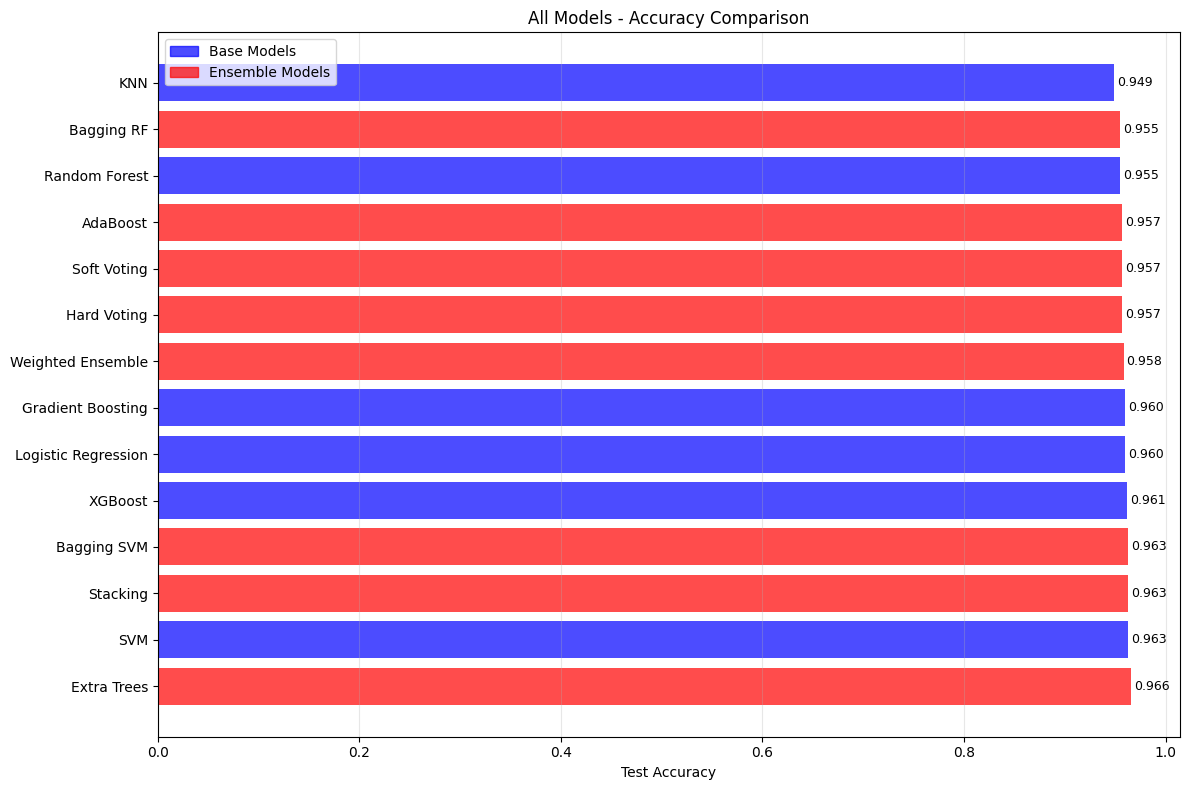


Accuracies saved to 'all_model_accuracies.csv'


In [19]:
# Add this code after your existing model training to extract accuracies clearly

print("ALL MODEL ACCURACIES - DETAILED VIEW")
print("=" * 60)

# Method 1: From comparison_df (if it exists from your code)
if 'comparison_df' in locals():
    print("From comparison_df:")
    print("-" * 30)
    for idx, row in comparison_df.iterrows():
        print(f"{row['Model']:<25}: {row['Test_Accuracy']:.4f} ({row['Model_Type']})")

# Method 2: Direct extraction from results dictionaries
print("\nDirect from results dictionaries:")
print("-" * 40)

# Base models accuracies
print("BASE MODELS:")
if 'base_results' in locals():
    for model_name, results in base_results.items():
        accuracy = results['Test_Accuracy']
        print(f"  {model_name:<20}: {accuracy:.4f}")

# Ensemble models accuracies
print("\nENSEMBLE MODELS:")
if 'ensemble_results' in locals():
    for model_name, results in ensemble_results.items():
        accuracy = results['Test_Accuracy']
        print(f"  {model_name:<20}: {accuracy:.4f}")

# Method 3: Create a clean accuracy-only table
print("\nACCURACY RANKING TABLE")
print("-" * 40)

all_accuracies = []

# Collect all accuracies
if 'base_results' in locals():
    for name, results in base_results.items():
        all_accuracies.append((name, results['Test_Accuracy'], 'Base'))

if 'ensemble_results' in locals():
    for name, results in ensemble_results.items():
        all_accuracies.append((name, results['Test_Accuracy'], 'Ensemble'))

# Sort by accuracy (highest first)
all_accuracies.sort(key=lambda x: x[1], reverse=True)

print(f"{'Rank':<4} {'Model':<25} {'Accuracy':<10} {'Type'}")
print("-" * 55)
for rank, (model, accuracy, model_type) in enumerate(all_accuracies, 1):
    print(f"{rank:<4} {model:<25} {accuracy:<10.4f} {model_type}")

# Summary statistics
accuracies_only = [acc[1] for acc in all_accuracies]
print(f"\nACCURACY STATISTICS:")
print(f"Best Accuracy:    {max(accuracies_only):.4f}")
print(f"Worst Accuracy:   {min(accuracies_only):.4f}")
print(f"Average Accuracy: {sum(accuracies_only)/len(accuracies_only):.4f}")
print(f"Total Models:     {len(accuracies_only)}")

# Method 4: Visual comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
models = [acc[0] for acc in all_accuracies]
accuracies = [acc[1] for acc in all_accuracies]
colors = ['blue' if acc[2] == 'Base' else 'red' for acc in all_accuracies]

bars = plt.barh(range(len(models)), accuracies, color=colors, alpha=0.7)
plt.yticks(range(len(models)), models)
plt.xlabel('Test Accuracy')
plt.title('All Models - Accuracy Comparison')
plt.grid(axis='x', alpha=0.3)

# Add accuracy values on bars
for i, (bar, accuracy) in enumerate(zip(bars, accuracies)):
    plt.text(accuracy + 0.003, i, f'{accuracy:.3f}', va='center', fontsize=9)

# Add legend
blue_patch = plt.Rectangle((0,0),1,1, color='blue', alpha=0.7, label='Base Models')
red_patch = plt.Rectangle((0,0),1,1, color='red', alpha=0.7, label='Ensemble Models')
plt.legend(handles=[blue_patch, red_patch])

plt.tight_layout()
plt.show()

# Method 5: Save accuracies to CSV for external analysis
accuracy_data = pd.DataFrame(all_accuracies, columns=['Model', 'Accuracy', 'Type'])
accuracy_data.to_csv('all_model_accuracies.csv', index=False)
print(f"\nAccuracies saved to 'all_model_accuracies.csv'")

In [20]:
# Enhanced Model Training with Both Train and Test Accuracy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def calculate_train_test_accuracy(models_dict, X_train, y_train, X_test, y_test):
    """
    Calculate both training and testing accuracy for all models
    """
    print("TRAIN vs TEST ACCURACY COMPARISON")
    print("=" * 50)

    train_test_results = {}

    for model_name, model in models_dict.items():
        print(f"\nEvaluating {model_name}...")

        # Training predictions
        y_train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)

        # Testing predictions
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Calculate overfitting metric
        overfitting = train_accuracy - test_accuracy

        # Additional metrics for test set
        test_f1 = f1_score(y_test, y_test_pred, average='weighted')
        test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
        test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)

        train_test_results[model_name] = {
            'Train_Accuracy': train_accuracy,
            'Test_Accuracy': test_accuracy,
            'Overfitting_Gap': overfitting,
            'Test_F1': test_f1,
            'Test_Precision': test_precision,
            'Test_Recall': test_recall
        }

        print(f"  Train Accuracy: {train_accuracy:.4f}")
        print(f"  Test Accuracy:  {test_accuracy:.4f}")
        print(f"  Gap (Train-Test): {overfitting:.4f}")

        # Overfitting warning
        if overfitting > 0.1:
            print(f"  ⚠️  HIGH OVERFITTING DETECTED!")
        elif overfitting > 0.05:
            print(f"  ⚠️  Moderate overfitting")
        else:
            print(f"  ✅ Good generalization")

    return train_test_results

def create_train_test_comparison_table(train_test_results):
    """
    Create comprehensive comparison table
    """
    df = pd.DataFrame(train_test_results).T
    df = df.round(4)

    # Sort by test accuracy
    df = df.sort_values('Test_Accuracy', ascending=False)

    print("\nTRAIN vs TEST ACCURACY TABLE")
    print("=" * 80)
    print(f"{'Model':<20} {'Train_Acc':<10} {'Test_Acc':<10} {'Gap':<8} {'F1':<8} {'Status'}")
    print("-" * 80)

    for model_name, row in df.iterrows():
        gap = row['Overfitting_Gap']
        if gap > 0.1:
            status = "HIGH_OVERFIT"
        elif gap > 0.05:
            status = "MOD_OVERFIT"
        elif gap < 0:
            status = "UNDERFIT"
        else:
            status = "GOOD"

        print(f"{model_name:<20} {row['Train_Accuracy']:<10.4f} {row['Test_Accuracy']:<10.4f} "
              f"{gap:<8.4f} {row['Test_F1']:<8.4f} {status}")

    return df

def visualize_train_test_comparison(train_test_results):
    """
    Create visualizations for train vs test accuracy
    """
    df = pd.DataFrame(train_test_results).T

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Train vs Test Accuracy Scatter Plot
    axes[0,0].scatter(df['Train_Accuracy'], df['Test_Accuracy'], s=100, alpha=0.7)

    # Add diagonal line for perfect generalization
    min_acc = min(df['Train_Accuracy'].min(), df['Test_Accuracy'].min())
    max_acc = max(df['Train_Accuracy'].max(), df['Test_Accuracy'].max())
    axes[0,0].plot([min_acc, max_acc], [min_acc, max_acc], 'r--', alpha=0.5, label='Perfect Generalization')

    # Add model labels
    for model_name, row in df.iterrows():
        axes[0,0].annotate(model_name[:8], (row['Train_Accuracy'], row['Test_Accuracy']),
                          xytext=(5, 5), textcoords='offset points', fontsize=8)

    axes[0,0].set_xlabel('Train Accuracy')
    axes[0,0].set_ylabel('Test Accuracy')
    axes[0,0].set_title('Train vs Test Accuracy')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Overfitting Gap Analysis
    colors = ['red' if gap > 0.1 else 'orange' if gap > 0.05 else 'green'
              for gap in df['Overfitting_Gap']]

    bars = axes[0,1].barh(range(len(df)), df['Overfitting_Gap'], color=colors, alpha=0.7)
    axes[0,1].set_yticks(range(len(df)))
    axes[0,1].set_yticklabels(df.index)
    axes[0,1].set_xlabel('Overfitting Gap (Train - Test)')
    axes[0,1].set_title('Overfitting Analysis')
    axes[0,1].axvline(x=0.05, color='orange', linestyle='--', alpha=0.5, label='Moderate Threshold')
    axes[0,1].axvline(x=0.1, color='red', linestyle='--', alpha=0.5, label='High Threshold')
    axes[0,1].legend()
    axes[0,1].grid(axis='x', alpha=0.3)

    # Add gap values on bars
    for i, (bar, gap) in enumerate(zip(bars, df['Overfitting_Gap'])):
        axes[0,1].text(gap + 0.001, i, f'{gap:.3f}', va='center', fontsize=9)

    # 3. Side-by-side Train/Test Accuracy
    x = np.arange(len(df))
    width = 0.35

    axes[1,0].bar(x - width/2, df['Train_Accuracy'], width, label='Train Accuracy', alpha=0.8)
    axes[1,0].bar(x + width/2, df['Test_Accuracy'], width, label='Test Accuracy', alpha=0.8)

    axes[1,0].set_xlabel('Models')
    axes[1,0].set_ylabel('Accuracy')
    axes[1,0].set_title('Train vs Test Accuracy Comparison')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(df.index, rotation=45, ha='right')
    axes[1,0].legend()
    axes[1,0].grid(axis='y', alpha=0.3)

    # 4. Model Performance Summary Heatmap
    metrics_for_heatmap = df[['Train_Accuracy', 'Test_Accuracy', 'Test_F1', 'Test_Precision', 'Test_Recall']]
    sns.heatmap(metrics_for_heatmap, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[1,1])
    axes[1,1].set_title('Performance Metrics Heatmap')

    plt.tight_layout()
    plt.show()

def identify_best_generalizing_models(train_test_results, top_n=3):
    """
    Identify models with best generalization (low overfitting + high test accuracy)
    """
    df = pd.DataFrame(train_test_results).T

    # Create a composite score: high test accuracy, low overfitting gap
    df['Generalization_Score'] = df['Test_Accuracy'] - (df['Overfitting_Gap'] * 0.5)
    df = df.sort_values('Generalization_Score', ascending=False)

    print(f"\nTOP {top_n} BEST GENERALIZING MODELS")
    print("=" * 50)

    for i, (model_name, row) in enumerate(df.head(top_n).iterrows(), 1):
        print(f"{i}. {model_name}")
        print(f"   Test Accuracy: {row['Test_Accuracy']:.4f}")
        print(f"   Train Accuracy: {row['Train_Accuracy']:.4f}")
        print(f"   Overfitting Gap: {row['Overfitting_Gap']:.4f}")
        print(f"   Generalization Score: {row['Generalization_Score']:.4f}")
        print()

    return df

# Modified training function that captures both train and test accuracy
def enhanced_model_training(models_dict, X_train, y_train, X_test, y_test):
    """
    Enhanced model training with comprehensive train/test evaluation
    """
    print("ENHANCED MODEL TRAINING WITH TRAIN/TEST ACCURACY")
    print("=" * 60)

    enhanced_results = {}

    for model_name, model in models_dict.items():
        print(f"\nTraining {model_name}...")

        # Train the model
        model.fit(X_train, y_train)

        # Training set evaluation
        y_train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_f1 = f1_score(y_train, y_train_pred, average='weighted')

        # Test set evaluation
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred, average='weighted')
        test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
        test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)

        # Probabilities for AUC (if available)
        if hasattr(model, 'predict_proba') and len(np.unique(y_test)) == 2:
            y_test_proba = model.predict_proba(X_test)[:, 1]
            test_auc = roc_auc_score(y_test, y_test_proba)
        else:
            test_auc = None
            y_test_proba = None

        enhanced_results[model_name] = {
            'Train_Accuracy': train_accuracy,
            'Train_F1': train_f1,
            'Test_Accuracy': test_accuracy,
            'Test_F1': test_f1,
            'Test_Precision': test_precision,
            'Test_Recall': test_recall,
            'Test_AUC': test_auc,
            'Overfitting_Gap': train_accuracy - test_accuracy,
            'Predictions': y_test_pred,
            'Probabilities': y_test_proba,
            'Model': model
        }

        print(f"✓ Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return enhanced_results

# Usage example for your existing code:
"""
# After defining your models but before training, use this:

# For base models
enhanced_base_results = enhanced_model_training(base_models, X_train_balanced, y_train_balanced, X_test_scaled, y_test)

# Create comparison
train_test_comparison = create_train_test_comparison_table(enhanced_base_results)

# Visualize
visualize_train_test_comparison(enhanced_base_results)

# Find best generalizing models
best_models = identify_best_generalizing_models(enhanced_base_results)
"""

# Quick function to add train accuracy to your existing results
def add_train_accuracy_to_existing_results(trained_models, X_train, y_train, existing_results):
    """
    Add train accuracy to your existing results dictionary
    """
    print("ADDING TRAIN ACCURACY TO EXISTING RESULTS")
    print("=" * 45)

    for model_name in existing_results.keys():
        if model_name in trained_models:
            model = trained_models[model_name]

            # Calculate train accuracy
            y_train_pred = model.predict(X_train)
            train_accuracy = accuracy_score(y_train, y_train_pred)

            # Add to existing results
            existing_results[model_name]['Train_Accuracy'] = train_accuracy
            existing_results[model_name]['Overfitting_Gap'] = train_accuracy - existing_results[model_name]['Test_Accuracy']

            print(f"{model_name:<20}: Train={train_accuracy:.4f}, Test={existing_results[model_name]['Test_Accuracy']:.4f}, Gap={train_accuracy - existing_results[model_name]['Test_Accuracy']:.4f}")

    return existing_results

In [21]:
# Add train accuracy to your existing results
print("CALCULATING TRAIN ACCURACY FOR EXISTING MODELS")
print("=" * 50)

# For base models
for model_name in base_results.keys():
    if model_name in trained_base_models:
        model = trained_base_models[model_name]

        # Calculate train accuracy
        y_train_pred = model.predict(X_train_balanced)
        train_accuracy = accuracy_score(y_train_balanced, y_train_pred)

        # Add to existing results
        base_results[model_name]['Train_Accuracy'] = train_accuracy
        base_results[model_name]['Overfitting_Gap'] = train_accuracy - base_results[model_name]['Test_Accuracy']

        print(f"{model_name:<20}: Train={train_accuracy:.4f}, Test={base_results[model_name]['Test_Accuracy']:.4f}")

# For ensemble models (if they exist)
if 'ensemble_results' in locals():
    for model_name in ensemble_results.keys():
        if model_name in trained_ensemble_models:
            model = trained_ensemble_models[model_name]
            y_train_pred = model.predict(X_train_balanced)
            train_accuracy = accuracy_score(y_train_balanced, y_train_pred)

            ensemble_results[model_name]['Train_Accuracy'] = train_accuracy
            ensemble_results[model_name]['Overfitting_Gap'] = train_accuracy - ensemble_results[model_name]['Test_Accuracy']

            print(f"{model_name:<20}: Train={train_accuracy:.4f}, Test={ensemble_results[model_name]['Test_Accuracy']:.4f}")

CALCULATING TRAIN ACCURACY FOR EXISTING MODELS
Logistic Regression : Train=0.9731, Test=0.9599
Random Forest       : Train=1.0000, Test=0.9552
Gradient Boosting   : Train=1.0000, Test=0.9599
XGBoost             : Train=1.0000, Test=0.9614
SVM                 : Train=0.9718, Test=0.9630
KNN                 : Train=1.0000, Test=0.9491
Hard Voting         : Train=1.0000, Test=0.9568
Soft Voting         : Train=1.0000, Test=0.9568
Stacking            : Train=0.9997, Test=0.9630
Bagging RF          : Train=0.9990, Test=0.9552
Bagging SVM         : Train=0.9750, Test=0.9630
AdaBoost            : Train=1.0000, Test=0.9568
Extra Trees         : Train=1.0000, Test=0.9660
Weighted Ensemble   : Train=1.0000, Test=0.9583
